## Assortativity

In this notebook, the assortativity, or homophily (based on the locality label) of the Harvey and Florence networks are established and tested for significance.

In [1]:
import os
import networkx as nx
import pandas as pd

from tex_funcs import set_tex_var as set_tex_var_import
from tex_funcs import df_to_tex as df_to_tex_import
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams.update({'font.size': 28})

# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 20}
# plt.rc('font', **font)

LATEX_DIR = './data/harvey_user_location/latex/'
LATEX_DAT_PATH = './data/harvey_user_location/latex/network-analysis.dat'
LATEX_TABLE_PATH = './data/harvey_user_location/latex/network-analysis-tabs.dat'

# All users user_class__gte=1, after excl. box filtered:
DIR = './data/harvey_user_location/graph_objs/'
HRV_GEXF = DIR + 'Harvey_network_data_20210929.gexf'

# LCC of users detected within first week of event, after excl. box filtered:
DIR = './data/florence_user_location/'
FLR_GEXF = DIR + 'Florence_network_data_20211218.gexf'


def set_tex_var(name, val, dec=3, desc=None):
    set_tex_var_import(name, val, LATEX_DAT_PATH, dec, desc)

def df_to_tex(df, cols=None, label='UNNAMED', caption='UNDEFINED', 
    width=0.8, row_sep=1, col_widths=None, dec_dict=None,sum_row=False):
    df_to_tex_import(df, LATEX_TABLE_PATH, cols, label, caption, width, row_sep, col_widths, dec_dict, sum_row)

# Convert int to str for latex export:
def int_to_str(x: int, capitalized=False):
    strings = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
    if x >= 10 or x < 0:
        return x
    elif capitalized:
        return strings[x].capitalize()
    else:
        return strings[x]

In [3]:
# If necessary, change attribute in Harvey gexf from 'lcl_profile' 
# to 'lcl_prf' to unify with Florence formatting:

G = nx.read_gexf(HRV_GEXF)
vals = nx.get_node_attributes(G, 'lcl_profile')
# If attribute exists, rename:
if len(vals):
    print('Renaming attribute...')
    # Create new attribute name
    new_attr = {k:{'lcl_prf':v} for k, v in vals.items()}
    nx.set_node_attributes(G, new_attr)
    # Remove old attribute
    for node in G.nodes:
        try:
            del G.nodes[node]['lcl_profile']
        except:
            pass
    # Overwrite old gexf
    nx.write_gexf(G, HRV_GEXF, prettyprint=True)

In [2]:
# ############### TESTING

# import pandas as pd

# DIR = './data/florence_user_location/'
# # Network before exlusion box applied, lcl_profile classifies all null vals as false 
# # nodes: 106732 edges: 3428033, lcl_prf: F: 58035 T: 21772
# FLR_GEXF = DIR + 'Florence_network_data_20210721.gexf'
# # Network after exclusion applied. Florence_network_data_20210929.gexf is most recent.
# # n: 100343 e: 2933280, lcl_prf: F: 61764 T: 7133
# FLR_GEXF2 = DIR + 'Florence_network_data_exclusion_20210729.gexf'
# FLR_GEXF3 = DIR + 'Florence_network_data_postExcl_UPDATELCLPRF_MORE_EDGES__20210729.gexf'
# FLR_GEXF4 = DIR + 'Florence_network_data_20210929.gexf'

# for filename in [FLR_GEXF, FLR_GEXF2, FLR_GEXF3, FLR_GEXF4]:
#     G = nx.read_gexf(filename)
#     print(G.number_of_nodes(), G.number_of_edges())
    
#     nodes = G.nodes(data=True)
#     df = pd.DataFrame.from_dict(dict(nodes), orient='index')
#     try:
#         print(df['lcl_prf'].value_counts())
#     except:
#         print(df['lcl_prf'].value_counts())
#     print('\n')

In [3]:
# No longer needed since updated HRV gexf
# ''' Convert string values used in harvey graph to boolean '''
# def str_to_bool(x):
#     if x == 'false':
#         return False
#     elif x == 'true':
#         return True
#     else:
#         return None

In [4]:
# Only run if processing entire notebook:

for file in [LATEX_DAT_PATH, LATEX_TABLE_PATH]:
    try:    
        os.remove(file)
    except:
        pass

### Importing Locations from File

In [5]:
DIR = './data/harvey_user_location/'
with open(DIR + 'locality_dict_hrv.txt') as json_file:
    hrv_locs = json.load(json_file)
print('Unique Harvey Locs:', len(hrv_locs))

DIR = './data/florence_user_location/'
with open(DIR + 'flr_locs.txt') as json_file:
    flr_locs = json.load(json_file)
print('Unique Florence Locs:', len(flr_locs))

Unique Harvey Locs: 8770
Unique Florence Locs: 29507


In [6]:
set_tex_var('hrvUniqLocs', len(hrv_locs))
set_tex_var('flrUniqLocs', len(flr_locs))

### Harvey Network

In [4]:
import networkx as nx

G = nx.read_gexf(HRV_GEXF)
    
# Make undirected:
# Note, bidirectional edges merged when undirected 
G2 = nx.Graph(G)

In [5]:
Gcc = max(nx.connected_components(G2), key=len)
G_lcc = G2.subgraph(Gcc)

lcc_nodes = '{:,.0f} ({:.2f})'.format(G_lcc.number_of_nodes(), G_lcc.number_of_nodes()/G.number_of_nodes())
lcc_edges = '{:,.0f} ({:.2f})'.format(G_lcc.number_of_edges(), G_lcc.number_of_edges()/G.number_of_edges())

hrv_g_row = {'Event':'Harvey', 'Nodes':'{:,.0f}'.format(G.number_of_nodes()), 'Edges':'{:,.0f}'.format(G.number_of_edges())}
hrv_lcc_row = {'Event':'Harvey$_{LCC}$', 'Nodes':lcc_nodes, 'Edges':lcc_edges}

Gcc = None
G_lcc = None

In [9]:
#Old numbers from pre Oct21 run

# #################### TEMP?
# Gcc = max(nx.connected_components(G2), key=len)
# G_lcc = G2.subgraph(Gcc)

# assort_coef = nx.attribute_assortativity_coefficient(G_lcc, 'lcl_prf')
# print('Harvey assortativity for G_lcc:', assort_coef)

# assort_coef = nx.attribute_assortativity_coefficient(G2, 'lcl_prf')
# print('Harvey assortativity for undirected graph:', assort_coef)
# assort_coef = nx.attribute_assortativity_coefficient(G, 'lcl_prf')
# print('Harvey assortativity for directed graph:', assort_coef)

In [10]:
Gcc = max(nx.connected_components(G2), key=len)
G_lcc = G2.subgraph(Gcc)

assort_coef = nx.attribute_assortativity_coefficient(G_lcc, 'lcl_prf')
print('Harvey assortativity for G_lcc:', assort_coef)

assort_coef = nx.attribute_assortativity_coefficient(G2, 'lcl_prf')
print('Harvey assortativity for undirected graph:', assort_coef)
assort_coef = nx.attribute_assortativity_coefficient(G, 'lcl_prf')
print('Harvey assortativity for directed graph:', assort_coef)

Harvey assortativity for G_lcc: 0.3998547718257325
Harvey assortativity for undirected graph: 0.3991675590255801
Harvey assortativity for directed graph: 0.40483549519018347


In [11]:
#Old numbers from pre Oct21 run

# # Excluding non-geocoded nodes:
# partition = [node for node, data in G2.nodes(data=True) if data.get('lcl_prf') != '']
# G2 = G2.subgraph(partition)
# print('{} nodes reduced to {}'.format(G.number_of_nodes(), G2.number_of_nodes()))

# assort_coef_1 = nx.attribute_assortativity_coefficient(G2, 'lcl_prf')
# print('Harvey assortativity for non-null profile location nodes, undirected:', assort_coef_1)

# G3 = G.subgraph(partition)
# assort_coef_2 = nx.attribute_assortativity_coefficient(G3, 'lcl_prf')
# print('Harvey assortativity for non-null profile location nodes, directed:', assort_coef_2)

In [12]:
# Excluding non-geocoded nodes:
partition = [node for node, data in G2.nodes(data=True) if data.get('lcl_prf') != None]
G2 = G2.subgraph(partition)
print('{} nodes reduced to {}'.format(G.number_of_nodes(), G2.number_of_nodes()))

assort_coef_1 = nx.attribute_assortativity_coefficient(G2, 'lcl_prf')
print('Harvey assortativity for non-null profile location nodes, undirected:', assort_coef_1)

G3 = G.subgraph(partition)
assort_coef_2 = nx.attribute_assortativity_coefficient(G3, 'lcl_prf')
print('Harvey assortativity for non-null profile location nodes, directed:', assort_coef_2)

31932 nodes reduced to 24855
Harvey assortativity for non-null profile location nodes, undirected: 0.6150662672353499
Harvey assortativity for non-null profile location nodes, directed: 0.624707991964388


In [13]:
# Harvey assortativity for non-null profile location nodes, directed:
set_tex_var('hrvAssortCoef', assort_coef_2, 3)

hrv_g_row = {'Event':'Harvey', 'Nodes':G.number_of_nodes(), 'Edges':G.number_of_edges()}
hrv_g2_row = {'Event':'Harvey$_{LCC}$', 'Nodes':G2.number_of_nodes(), 'Edges':G2.number_of_edges()}
hrv_assort_row = {'Event': 'Harvey', 'Nodes$_{total}$':G.number_of_nodes(), 'Nodes$_{filtered}$':G2.number_of_nodes(), 
                  'Assortativity':assort_coef_2}

Assortativity based on the coded label is also calculated. This uses a subgraph of only nodes which have been coded.

In [14]:
G3 = G.copy()

# Manually defining codes to match for as null-values are defined in different ways
codes = ["Non-Witness", "Witness", "Unsure"]
nodes = [
    node
    for node, data
    in G3.nodes(data=True)
    if data.get("user_code") in codes
    ]
G3 = G3.subgraph(nodes)

print("{} nodes reduced to {} coded nodes.\n".format(G.number_of_nodes(), G3.number_of_nodes()))

attrs = {}
for node, data in G3.nodes(data=True):
    if data.get("user_code") != "Non-Witness": # 'Unsure' codes counted as 'True'
        attrs[node] = {"user_code":True}
    else:
        attrs[node] = {"user_code":False}
nx.set_node_attributes(G3, attrs)

assort_coef_1 = nx.attribute_assortativity_coefficient(G3, 'user_code')
print('Harvey coded dataset assortativity, directed:', assort_coef_1)
assort_coef_2 = nx.attribute_assortativity_coefficient(nx.Graph(G3), 'user_code')
print('Harvey coded dataset assortativity, undirected:', assort_coef_2)


# Check LCC (of full graph)
Gcc = max(nx.connected_components(G2), key=len)
G4 = G3.subgraph(Gcc)

assort_coef_3 = nx.attribute_assortativity_coefficient(G4, 'user_code')
print('Harvey LCC coded dataset assortativity, directed:', assort_coef_3)
assort_coef_4 = nx.attribute_assortativity_coefficient(nx.Graph(G4), 'user_code')
print('Harvey LCC coded dataset assortativity, undirected:', assort_coef_4)

31932 nodes reduced to 1500 coded nodes.

Harvey coded dataset assortativity, directed: 0.5419992727398659
Harvey coded dataset assortativity, undirected: 0.47963128159381513
Harvey LCC coded dataset assortativity, directed: 0.5551825977630439
Harvey LCC coded dataset assortativity, undirected: 0.4990638651965883


In [15]:
val = assort_coef_1

# Harvey coded dataset assortativity, directed:
set_tex_var('hrvAssortCoefCoded', val, 3, "Harvey coded dataset assortativity, directed:")

if val >= 0.5:
    interp = 'strong'
elif val >= 0.3:
    interp = 'moderate'
elif val > 0:
    interp = 'low'
else:
    raise Exception('No correlation, check how value is used in document.')
set_tex_var('hrvAssortCoefCodedInterpretation', interp)

### Florence Network
Now the same calculations are repeated for the Florence dataset (excluding the coded subgraph)

The Florence network used represents the first 7 days of collected data.

In [2]:
import networkx as nx

G = nx.read_gexf(FLR_GEXF)
    
# Make undirected:
# Note, bidirectional edges merged when undirected 
G2 = nx.Graph(G)

# Check if already LCC:
if len([x for x in nx.connected_components(G2)]) == 1:
    print('Graph is single component.')
else:
    # TODO: Handle
    print('WARNING: G not single component. Unhandled in following cells')
    
    node_counts = dict()
    for i in [len(x) for x in components]:
      node_counts[i] = node_counts.get(i, 0) + 1
    for k,v in node_counts.items():
        print(k, '\t', v)

In [15]:
########## NOTE: vals hardcoded as file is already the LCC subgraph.
orig_nodes = 124558
orig_edges = 3428659
##########

# TESTING LCC paring (Previously commented out)
# WARNING: Should be dividing by orig_nodes not G.number_of_nodes() if G isn't total graph
Gcc = max(nx.connected_components(G2), key=len)
G_lcc = G2.subgraph(Gcc)
lcc_nodes = '{:,.0f} ({:.3f})'.format(G_lcc.number_of_nodes(), G_lcc.number_of_nodes()/G.number_of_nodes())
lcc_edges = '{:,.0f} ({:.3f})'.format(G_lcc.number_of_edges(), G_lcc.number_of_edges()/G.number_of_edges())
flr_g_row_TESTING = {'Event':'Florence', 'Nodes':'{:,.0f}'.format(orig_nodes), 'Edges':'{:,.0f}'.format(orig_edges)}
flr_lcc_row_TESTING = {'Event':'Florence$_{LCC}$', 'Nodes':lcc_nodes, 'Edges':lcc_edges}
Gcc = None
G_lcc = None
################################

lcc_nodes = '{:,.0f} ({:.2f})'.format(G.number_of_nodes(), G.number_of_nodes()/orig_nodes)
lcc_edges = '{:,.0f} ({:.2f})'.format(G.number_of_edges(), G.number_of_edges()/orig_edges)

flr_g_row = {'Event':'Florence', 'Nodes':'{:,.0f}'.format(orig_nodes), 'Edges':'{:,.0f}'.format(orig_edges)}
flr_lcc_row = {'Event':'Florence$_{LCC}$', 'Nodes':lcc_nodes, 'Edges':lcc_edges}


In [20]:
# TODO: choose correct comparison, check proportions are correctly calculated
print(flr_g_row) # hardcoded counts
print(flr_lcc_row) # G counts
print(flr_lcc_row_TESTING) # LCC counts

{'Event': 'Florence', 'Nodes': '124,558', 'Edges': '3,428,659'}
{'Event': 'Florence$_{LCC}$', 'Nodes': '100,343 (0.81)', 'Edges': '2,933,280 (0.86)'}
{'Event': 'Florence$_{LCC}$', 'Nodes': '83,693 (0.834)', 'Edges': '2,034,138 (0.693)'}


In [18]:
assort_coef = nx.attribute_assortativity_coefficient(G2, 'lcl_prf')
print('Florence assortativity for undirected graph:', assort_coef)
assort_coef = nx.attribute_assortativity_coefficient(G, 'lcl_prf')
print('Florence assortativity for directed graph:', assort_coef)

Florence assortativity for undirected graph: 0.13897354549452934
Florence assortativity for directed graph: 0.12679334452939126


In [19]:
# Excluding non-geocoded nodes:
orig_nodes = G2.number_of_nodes()
partition = [node for node, data in G2.nodes(data=True) if data.get('lcl_prf') in [True, False]]
G2 = G2.subgraph(partition)
print('{} nodes reduced to {}'.format(orig_nodes, G2.number_of_nodes()))

assort_coef_1 = nx.attribute_assortativity_coefficient(G2, 'lcl_prf')
print('Florence assortativity for non-null profile location nodes, undirected:', assort_coef_1)

G3 = G.subgraph(partition)
assort_coef_2 = nx.attribute_assortativity_coefficient(G3, 'lcl_prf')
print('Florence assortativity for non-null profile location nodes, directed:', assort_coef_2)

100343 nodes reduced to 68897
Florence assortativity for non-null profile location nodes, undirected: 0.5130113407592274
Florence assortativity for non-null profile location nodes, directed: 0.4954217649027176


In [20]:
set_tex_var('flrAssortCoef', assort_coef_2, 3, 
            "Florence assortativity for non-null profile location nodes, directed:")

flr_assort_row = {'Event': 'Florence', 'Nodes$_{total}$':orig_nodes, 
                  'Nodes$_{filtered}$':G2.number_of_nodes(), 'Assortativity':assort_coef_2}

In [21]:
# Run again on LCC:
# (Need to manually compare to values calculated above and decide on relevance)
print("Original size:", G.number_of_nodes(), G.number_of_edges())

G2 = nx.Graph(G)
Gcc = max(nx.connected_components(G2), key=len)
G2 = G2.subgraph(Gcc)
G_lcc = G.subgraph(Gcc)

print("LCC size:", G2.number_of_nodes(), G2.number_of_edges())

assort_coef = nx.attribute_assortativity_coefficient(G2, 'lcl_prf')
print('Florence LCC assortativity for undirected graph:', assort_coef)
assort_coef = nx.attribute_assortativity_coefficient(G_lcc, 'lcl_prf')
print('Florence LCC assortativity for directed graph:', assort_coef)

# Excluding non-geocoded nodes:
orig_nodes = G2.number_of_nodes()
#partition = [node for node, data in G2.nodes(data=True) if data.get('lcl_prf') != None]
partition = [node for node, data in G2.nodes(data=True) if data.get('lcl_prf') in [True, False]]
G2 = G2.subgraph(partition)
print('{} nodes reduced to {}'.format(orig_nodes, G2.number_of_nodes()))


assort_coef_1 = nx.attribute_assortativity_coefficient(G2, 'lcl_prf')
print('Florence LCC assortativity for non-null profile location nodes, undirected:', assort_coef_1)

G3 = G.subgraph(partition)
assort_coef_2 = nx.attribute_assortativity_coefficient(G3, 'lcl_prf')
print('Florence LCC assortativity for non-null profile location nodes, directed:', assort_coef_2)

Original size: 100343 2933280
LCC size: 83693 2034138
Florence LCC assortativity for undirected graph: 0.13882541478748095
Florence LCC assortativity for directed graph: 0.1266199611686239
83693 nodes reduced to 62447
Florence LCC assortativity for non-null profile location nodes, undirected: 0.5130263727817486
Florence LCC assortativity for non-null profile location nodes, directed: 0.4954374484391542


### Exporting Tables

In [22]:
# Testing with uncommented second FLR cell
import pandas as pd

df = pd.DataFrame([hrv_g_row, hrv_lcc_row, {}, flr_g_row_TESTING, flr_lcc_row_TESTING])
df = df[['Event', 'Nodes', 'Edges']]
df = df.fillna('')
df

,Event,Nodes,Edges
0,Harvey,31932,101096
1,Harvey$_{LCC}$,"18,410 (0.58)","76,341 (0.76)"
2,,,
3,Florence,"124,558","3,428,659"
4,Florence$_{LCC}$,"83,693 (0.834)","2,034,138 (0.693)"


In [23]:
import pandas as pd

df = pd.DataFrame([hrv_g_row, hrv_lcc_row, {}, flr_g_row, flr_lcc_row])
df = df[['Event', 'Nodes', 'Edges']]
df = df.fillna('')
df

,Event,Nodes,Edges
0,Harvey,31932,101096
1,Harvey$_{LCC}$,"18,410 (0.58)","76,341 (0.76)"
2,,,
3,Florence,"124,558","3,428,659"
4,Florence$_{LCC}$,"100,343 (0.81)","2,933,280 (0.86)"


In [69]:
# Older DF
import pandas as pd

df = pd.DataFrame([hrv_g_row, hrv_lcc_row, {}, flr_g_row, flr_lcc_row])
df = df[['Event', 'Nodes', 'Edges']]
df = df.fillna('')
df

,Event,Nodes,Edges
0,Harvey,"31,932","101,096"
1,Harvey$_{LCC}$,"18,410 (0.58)","76,341 (0.76)"
2,,,
3,Florence,"124,558","3,428,659"
4,Florence$_{LCC}$,"106,732 (0.86)","3,428,033 (1.00)"


In [24]:
df_to_tex(df, label='network-size', caption='Network Sizes', width=0.8, row_sep=0)

Writing df to file as tex...


In [25]:
df = pd.DataFrame([hrv_assort_row, flr_assort_row])
df = df[['Event', 'Nodes$_{total}$', 'Nodes$_{filtered}$', 'Assortativity']]
df

,Event,Nodes$_{total}$,Nodes$_{filtered}$,Assortativity
0,Harvey,31932,24855,0.624708
1,Florence,100343,68897,0.495422


In [15]:
# Older DF
df = pd.DataFrame([hrv_assort_row, flr_assort_row])
df = df[['Event', 'Nodes$_{total}$', 'Nodes$_{filtered}$', 'Assortativity']]
df

,Event,Nodes$_{total}$,Nodes$_{filtered}$,Assortativity
0,Harvey,31932,21157,0.626523
1,Florence,106732,79807,0.541778


In [26]:
dec_d = {'Nodes$_{total}$':0, 'Nodes$_{filtered}$':0, 'Assortativity':3}
#col_widths = 'X[-1,lm] X[-1,rm] X[-1,rm] X[-1,rm]'
col_widths = None
df_to_tex(df, label='assortativity', caption='Network Assortativity Coefficient', width=0.8, row_sep=0, dec_dict=dec_d, col_widths=col_widths)

Writing df to file as tex...


### Significance Testing
#### Jackknife Method
To test the significance of the findings above, we can calculate the st-dev of the assortativity (or any metric) using the 'jacknife method' in which for each edge, a graph excluding that edge is created and assortativity calculated. 

By regarding each of the M edges as independent, the standard deviation for r satisfies:

$$\sigma^2_r = \sum_{i=1}^{M} (r_i-r)^2$$

where $r_i$ is the value of r for the network in which the ith edge is removed (Newman, 2003, Mixing patterns in networks; B. Efron, 1979, Computers and the Theory of Statistics: Thinking the Unthinkable)

assortativity: 0.6589217919514058


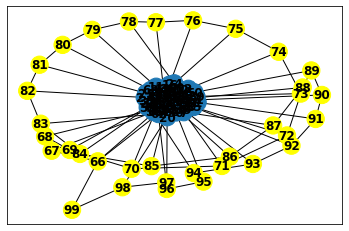

In [27]:
# Creating toy graph for demonstration

import networkx as nx
import random

tot = 100
split = int(tot/3)*2
G = nx.Graph()
G.add_nodes_from([i for i in range(tot)])
attrs = {i:{'lcl':(True if i < split else False)} for i in range(tot)}
nx.set_node_attributes(G, attrs)
node_color = [('#1f78b4' if i < split else '#ffff00') for i in range(tot)]

for n in range(split):
    for m in range(split):
        G.add_edge(n,m)
for n in range(split,tot):
    G.add_edge(n,n-1)
    G.add_edge(n, random.randint(0,split))
#G.add_edge(0,split+1)

assort = nx.attribute_assortativity_coefficient(G, 'lcl')
print('assortativity:', assort)

nx.draw_networkx(G, with_labels=True, node_color=node_color, font_weight='bold')

In [28]:
# Calculate Std Deviation using jackknife method:
import math

print('Edges:', G.number_of_edges())
assort = nx.attribute_assortativity_coefficient(G, 'lcl')

std = 0
for (u,v) in G.edges():
    G2 = G.copy()
    G2.remove_edge(u,v)
    assort_i = nx.attribute_assortativity_coefficient(G2, 'lcl')
    std += (assort_i - assort)**2

print('Assort: {:.4}, std: {:.4}'.format(assort, math.sqrt(std)))

Edges: 2279
Assort: 0.6589, std: 0.05564


#### Monte Carlo Simulations
However, for a large enough graph, iterating through M subgraphs is expensive. As an alternative, we can simulate an ensemble of null models (based on the configuration model) and calculate the mean and standard deviation for their assortativity values. The Z score for the observed value can then be calculated as:

\begin{equation}\label{eq:z-score}
  Z = \frac{r_{observed}-r_{rand}}{\sigma(r_{rand})}
\end{equation}

and converted into a p-value.

In [42]:
import numpy
from scipy.stats import norm

# Simulate n_simulation configuration models of network G and calculate
# assortativity based on label attr_label.

# NOTE: config models may be undirected or otherwise not respect the 
# direction of node edges, needs further testing.

def monte_carlo_sim(G, attr_label, n_simulation, verbose=True):
    if verbose:
        print('Graph nodes: {}, edges: {}'.format(G.number_of_nodes(), G.number_of_edges()))
        
    # Creating parameters for configuration model:
    seq_lbl = [(G.degree(n[0]), n[1][attr_label]) for n in G.nodes(data=True)]
    seq = [x[0] for x in seq_lbl]
    labels = [x[1] for x in seq_lbl]
    index = [i for i in range(len(labels))]
    attrs = dict(zip(index, labels))

    # Generating configuration models:
    config_vals = []
    for i in range(n_simulation):
        if i%int(n_simulation/10) == 0 and verbose:
            print('{:.0f}% -- Generating graph {} of {}'.format(i/n_simulation*100, i, n_simulation))
        G2 = nx.configuration_model(seq, seed=i**i)
        nx.set_node_attributes(G2, attrs, name=attr_label)
        assort_coef = nx.attribute_assortativity_coefficient(G2, attr_label)
        config_vals.append(assort_coef)

    assort_coef = nx.attribute_assortativity_coefficient(G, attr_label)
    print('\nOriginal Network assortativity: {:.5f}'.format(assort_coef))
    
    config_mean = numpy.array(config_vals).mean()
    config_std = numpy.array(config_vals).std()
    print('\nConfig assort mean: {:.4f}'.format(config_mean))
    print('Config assort std: {:.4f}'.format(config_std))

    zscore = (assort_coef-config_mean)/config_std
    pval = norm.sf(abs(zscore))*2
    print('\nOriginal Network Z-Score: {:.4f}'.format(zscore))
    print('p-val:', pval)
    
    return {'assort_coef':assort_coef,
            'zscore':zscore, 
            'pval':pval,
            'config_mean':config_mean, 
            'config_std':config_std,
            'config_vals':config_vals}

In [43]:
import networkx as nx

LCL_PRF_NULL_VAL = ''
N_SIMULATION = 100

G = nx.read_gexf(HRV_GEXF)
#Subset of graph with valid lcl_profile values
nodes = [
    node
    for node, data
    in G.nodes(data=True)
    if data.get(LCL_PRF_LABEL) in [True, False]
]
G = G.subgraph(nodes)

assort_dict = monte_carlo_sim(G, 'lcl_prf', N_SIMULATION)

Graph nodes: 24855, edges: 79905
0% -- Generating graph 0 of 100
10% -- Generating graph 10 of 100
20% -- Generating graph 20 of 100
30% -- Generating graph 30 of 100
40% -- Generating graph 40 of 100
50% -- Generating graph 50 of 100
60% -- Generating graph 60 of 100
70% -- Generating graph 70 of 100
80% -- Generating graph 80 of 100
90% -- Generating graph 90 of 100

Original Network assortativity: 0.62471

Config assort mean: -0.0003
Config assort std: 0.0039

Original Network Z-Score: 158.5972
p-val: 0.0


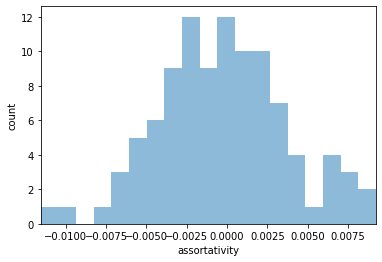

In [44]:
import numpy as np

data = assort_dict['config_vals']

bins = np.linspace(min(data), max(data), 20) # fixed number of bins

plt.xlim([min(data), max(data)])

plt.hist(data, bins=bins, alpha=0.5)
#plt.title('Assortativity of Configuration Models')
plt.xlabel('assortativity')
plt.ylabel('count')

plt.savefig(LATEX_DIR + 'assort-monte-carlo-dist-hrv.png', bbox_inches='tight')
plt.show()

In [45]:
###
### Repeating simulation for Florence network
###

import networkx as nx

LCL_PRF_LABELS = [True, False]

G = nx.read_gexf(FLR_GEXF)
#Subset of graph with valid lcl_profile values
nodes = [node for node, data in G.nodes(data=True) if data.get(LCL_PRF_LABEL) in LCL_PRF_LABELS]
G = G.subgraph(nodes)

assort_dict = monte_carlo_sim(G, 'lcl_prf', N_SIMULATION)

Graph nodes: 68897, edges: 1889035
0% -- Generating graph 0 of 100
10% -- Generating graph 10 of 100
20% -- Generating graph 20 of 100
30% -- Generating graph 30 of 100
40% -- Generating graph 40 of 100
50% -- Generating graph 50 of 100
60% -- Generating graph 60 of 100
70% -- Generating graph 70 of 100
80% -- Generating graph 80 of 100
90% -- Generating graph 90 of 100

Original Network assortativity: 0.49542

Config assort mean: -0.0000
Config assort std: 0.0008

Original Network Z-Score: 658.8140
p-val: 0.0


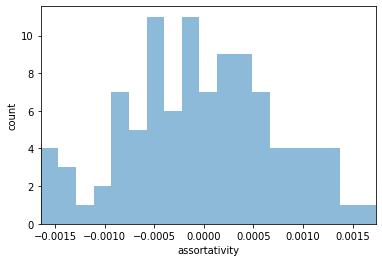

In [46]:
data = assort_dict['config_vals']

bins = np.linspace(min(data), max(data), 20) # fixed number of bins

plt.xlim([min(data), max(data)])

plt.hist(data, bins=bins, alpha=0.5)
#plt.title('Assortativity of Configuration Models')
plt.xlabel('assortativity')
plt.ylabel('count')

plt.savefig(LATEX_DIR + 'assort-monte-carlo-dist-flr.png', bbox_inches='tight')
plt.show()

In [47]:
set_tex_var('MCSimN', N_SIMULATION)

In [47]:
###
###
### TEMP TESTING MONTE CARLO SIM
###
###

assortativity: 0.7738277919863599


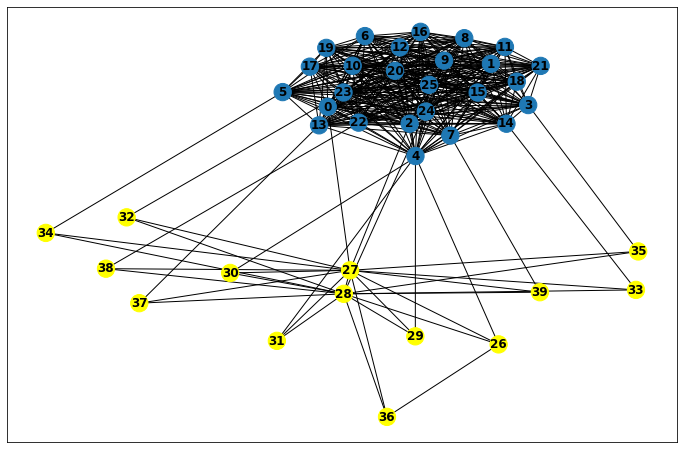

In [41]:
import networkx as nx
import random

tot = 40
split = int(tot/3)*2

G = nx.Graph()
G.add_nodes_from([i for i in range(tot)])

attrs = {i:{'lcl':(True if i < split else False)} for i in range(tot)}
nx.set_node_attributes(G, attrs)

for n in range(split):
    for m in range(split):
        G.add_edge(n,m)
for n in range(split,tot):
    G.add_edge(n,split+1)
    G.add_edge(n,split+2)
    G.add_edge(n, random.randint(0,split))
G.add_edge(0,split+1)


print('assortativity:', nx.attribute_assortativity_coefficient(G, 'lcl'))

node_color = [('#1f78b4' if i < split else '#ffff00') for i in range(tot)]
nx.draw_networkx(G, with_labels=True, node_color=node_color, font_weight='bold')

In [53]:
import numpy

N_SIMULATIONS = 10000

seq_lbl = [(G.degree(n[0]), n[1]['lcl']) for n in G.nodes(data=True)]
seq = [x[0] for x in seq_lbl]
labels = [x[1] for x in seq_lbl]
index = [i for i in range(len(labels))]
attrs = dict(zip(index, labels))

vals = []
for i in range(N_SIMULATIONS):
    if i%int(N_SIMULATIONS/10) == 0:
        print('{:.0f}% - {} of {}'.format(i/N_SIMULATIONS*100, i, N_SIMULATIONS))
    G2 = nx.configuration_model(seq, seed=i**i)
    nx.set_node_attributes(G2, attrs, name='lcl')
    assort_coef = nx.attribute_assortativity_coefficient(G2, 'lcl')
    vals.append(assort_coef)
   
print('\n')
print('Config assort mean:', numpy.array(vals).mean())
print('Config assort std:', numpy.array(vals).std())

#node_color = [('#1f78b4' if i < 10 else '#ffff00') for i in attrs.keys()]
#nx.draw_networkx(G2, with_labels=True, node_color=node_color, font_weight='bold')

0% - 0 of 10000
10% - 1000 of 10000
20% - 2000 of 10000
30% - 3000 of 10000
40% - 4000 of 10000
50% - 5000 of 10000
60% - 6000 of 10000
70% - 7000 of 10000
80% - 8000 of 10000
90% - 9000 of 10000


Config assort mean: -0.007900598733420517
Config assort std: 0.04849160656035515


In [46]:
# import json

# TEMP_FILENAME = './data/harvey_user_location/latex/temp_data.json'

# with open(TEMP_FILENAME, 'w') as outfile:
#     json.dump(vals, outfile)

In [47]:
# import json

# TEMP_FILENAME = './data/harvey_user_location/latex/temp_data.json'

# with open(TEMP_FILENAME) as json_file:
#     vals = json.load(json_file)

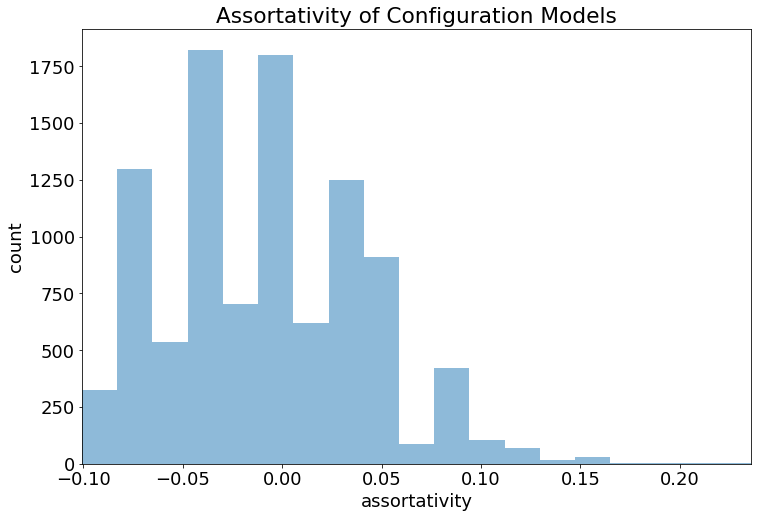

In [48]:
import numpy as np
from matplotlib import pyplot as plt

bins = np.linspace(min(vals), 
                   max(vals),
                   20) # fixed number of bins

plt.xlim([min(vals), max(vals)])

plt.hist(vals, bins=bins, alpha=0.5)
plt.title('Assortativity of Configuration Models')
plt.xlabel('assortativity')
plt.ylabel('count')

plt.show()

## Community Detection
In this section, a suite of community detection algorithms are run on the graph objects. The strength of community partitions is then measured using assortativity. The resulting community structures are then evaluated for their correlation with the locality label to determine whether community structure provides predictive value for user locality.

In [2]:
# Modularity:   https://scholar.google.com/scholar?q=Finding+community+structure+in+very+large+networks
# Label Prop:   https://neo4j.com/docs/graph-algorithms/current/algorithms/label-propagation/#algorithms-label-propagation-sample
# Louvain:      https://github.com/taynaud/python-louvain/blob/master/docs/index.rst

from networkx.algorithms.community import (greedy_modularity_communities, 
                                            label_propagation_communities, 
                                            asyn_lpa_communities, 
                                            asyn_fluidc, girvan_newman)
import community as community_louvain
from collections import Counter
import time

def calc_community_metrics(G):
    ''' 
    Returns a graph object enhanced with various community 
    metrics added as node attributes.
    
    Notes:
    - If return_lcc=True, the returned graph is undirected.
    - algorithms runs on LCC regardless of return_lcc value
    '''
    print('Calculating community metrics for graph. {} nodes and {} edges...'
              .format(len(G), G.number_of_edges()))

    # Create undirected LCC graph (required for some community detection algorithms):
    H = nx.Graph(G)
    H0 = get_giant_component(H)
    
#     print('Calculating c_modularity...')
#     start = time.time()
#     c_modularity = list(greedy_modularity_communities(H0))
#     print('Finished in {:.2f} seconds'.format(time.time()-start))
    
    print('Calculating c_label_prop...')
    start = time.time()
    c_label_prop = list(label_propagation_communities(H0))
    c_label_prop = sorted(c_label_prop, key=len, reverse=True)
#     print('Finished in {:.2f} seconds'.format(time.time()-start))
    
    print('Calculating c_label_prop_asyn...')
    start = time.time()
    c_label_prop_asyn = list(asyn_lpa_communities(H0))
    c_label_prop_asyn = sorted(c_label_prop_asyn, key=len, reverse=True)
#     print('Finished in {:.2f} seconds'.format(time.time()-start))
    
    # TOO SLOW:
    # print('Calculating c_girvan_newman...')
    # c_girvan_newman = list(girvan_newman(H0))
    
    print('Calculating c_louvain...')
    start = time.time()
    partition = community_louvain.best_partition(H0)
    # Rank indices by size
    counter = Counter(partition.values())
    ranking = sorted(counter, key=counter.get, reverse=True)
    partition_sorted = {k: ranking.index(v) for k, v in partition.items()}
#     print('Finished in {:.2f} seconds'.format(time.time()-start))
    
    # Set fluid_community_number to the average of the values determined by the other algorithms
#     fluid_community_number = round(sum([len(x) for x in [c_modularity, c_label_prop, c_label_prop_asyn, counter]]) / 4)
    # Set fluid_community_number to the same as greedy_modularity
#    fluid_community_number = len(c_modularity)
    fluid_community_number = len(counter) # Number of Louvain communities
    print('Calculating c_fluid...')
    start = time.time()
    c_fluid = list(asyn_fluidc(H0, fluid_community_number))
    c_fluid = sorted(c_fluid, key=len, reverse=True)
#     print('Finished in {:.2f} seconds'.format(time.time()-start))
    

#     print('Adding data as node attributes...')
    community_output_dict = {
                            #'c_greedy_modularity': c_modularity,
                            'c_label_propogation': c_label_prop,
                            'c_label_prop_asyn': c_label_prop_asyn,
                            'c_fluid': c_fluid,
                            # 'c_girvan_newman': c_girvan_newman
                            }
    for key in community_output_dict:
        community_dict = {}
        for i, c in enumerate(community_output_dict[key]):
            for name in c:
                community_dict[name] = i
        nx.set_node_attributes(G, community_dict, key)
    # (Louvain package returns a different format):
    nx.set_node_attributes(G, partition_sorted, 'c_louvain_method')

    return G


def get_giant_component(G):
    ''' Returns largest connected component of graph '''
    Gcc = max(nx.connected_components(G), key=len)
    orig_nodes = len(G)
    orig_edges = G.number_of_edges()
    G = G.subgraph(Gcc)
    #G0 = nx.connected_component_subgraphs(H)[0]
    print('Largest component contains {} nodes ({:.1f}%) and {} edges ({:.1f}%).'
              .format(len(G), len(G)/orig_nodes*100, G.number_of_edges(), G.number_of_edges()/orig_edges*100))
    return G

In [3]:
# # Calculate the assortativity coeffficient
# # Reference: Newman, M. (2018). Networks. p211
# # Adapted from https://networkx.github.io/documentation/stable/_modules/networkx/algorithms/community/quality.html

# # Appears to return the same value as nx.attribute_assortativity_coefficient(G, col)

# from itertools import product
# from networkx.algorithms.community.community_utils import is_partition

# def assortativity_coef(G, communities, weight='weight'):
#     if not isinstance(communities, list):
#         communities = list(communities)
#     if not is_partition(G, communities):
#         raise Exception("Not a partition")
#     if G.is_directed():
#         raise Exception("Directed not supported")
#     if G.is_multigraph():
#         raise Exception("Multigraphs not yet supported")

#     m = G.size(weight=weight)

#     out_degree = dict(G.degree(weight=weight))
#     in_degree = out_degree # Redundant as only undirected supported
#     norm = 1 / (2 * m)

#     def val(u, v):
#         try:
#             w = G[u][v].get(weight, 1)
#         except KeyError:
#             w = 0
#         # Double count self-loops if the graph is undirected.
#         #if u == v:
#         #    w *= 2
#         return w - in_degree[u] * out_degree[v] * norm

#     def val2(u, v):
#         return in_degree[u] * out_degree[v] * norm

#     Q = sum(val(u, v) for c in communities for u, v in product(c, repeat=2))

#     Qmax = ((2*m) - sum(val2(u, v) for c in communities for u, v in product(c, repeat=2)))

#     return Q, (Q / Qmax)

               

# def get_assort(G, label_name, label_values=None):
#     # Note: labels is a 2d array to support merging labels by providing arg label_values.
#     if not label_values:
#         label_values = [[x] for x in set(nx.get_node_attributes(G, label_name).values())]
#     partition = []
#     for label in label_values:
#         community = [node for node, data in G.nodes(data=True) if data.get(label_name) in label]
#         partition.append(community)
#     Q, assort_value = assortativity_coef(G, partition)
#     return Q, assort_value

# def get_comm_sizes(G, label_name, label_values=None):
#     # Note: labels is a 2d array to support merging labels by providing arg label_values.
#     # Note: Returned dict converts label names to str if any labels are merged
#     if not label_values:
#         label_values = [[x] for x in set(nx.get_node_attributes(G, label_name).values())]
#     has_merged_labels = max([len(x) for x in label_values]) > 1
#     d_len = {}
#     for label in label_values:
#         # Handle case where label arr contains multiple vals
#         if has_merged_labels:
#             label = [str(x) for x in label]
#             label_key = '-'.join(label)
#         else:
#             label_key = label[0]
#         d_len[label_key] = len([node for node, data in G.nodes(data=True) if data.get(label_name) in label])
#     return d_len

# # Simpler method without merging support
# # def get_comm_sizes(G, label_name):
# #     label_values = [[x] for x in set(nx.get_node_attributes(G, label_name).values())]
# #     d_len = {}
# #     for label in label_values:
# #         d_len[label_str] = len([node for node, data in G.nodes(data=True) if data.get(label_name) == label])
# #     return d_len

In [4]:
# Generate and export DF to Latex
import pandas as pd

def get_comm_summary_df(G):
    nodes = G.nodes(data=True)
    df_comm = pd.DataFrame.from_dict(dict(nodes), orient='index')
    nodes = None
    #df_comm = df_comm[['c_modularity', 'c_label_prop', 'c_label_prop_asyn', 'c_fluid', 'c_louvain']]
    #df_comm = df_comm.reset_index(drop=True)
    comm_titles = [x for x in df_comm.columns if x[:2] == "c_"]

    summary_dict = {}
    for col in comm_titles:
        s = df_comm[col]
        n_comm = s.value_counts().size
        min_comm = s.value_counts().min()
        max_comm = s.value_counts().max()
    #     vals = get_comm_sizes(G, col).values()
    #     n_comm = len(vals)
    #     min_comm = min(vals)
    #     max_comm = max(vals)
        assort_coef = nx.attribute_assortativity_coefficient(G, col)
        #Q, assort_coef = get_assort(G, col)
        summary_dict[col[2:]] = [col[2:], assort_coef, n_comm, max_comm, min_comm]

    cols = ["Algorithm", "Assortativity Coefficient", "Number of Communities (C)", "Largest C (nodes)", "Smallest C (nodes)"]
    comm_summary_df = pd.DataFrame.from_dict(summary_dict, orient='index', columns=cols)
    return(comm_summary_df)


def generate_config_model(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    Gc = nx.configuration_model(degree_sequence)
    # Remove parallel edges and self loops:
    Gc = nx.Graph(Gc)
    #Gc.remove_edges_from(Gc.selfloop_edges())
    return(Gc)

In [5]:
N_SIMULATIONS = 10

'''
Run community detection on N_SIMULATIONS
configuration models based on G and return
average values as DataFrame.
'''
def calc_config_assort(G, n_simulations = 10):
    for i in range(n_simulations):
        print('\nRunning config model {}...'.format(i+1))
        G_config = generate_config_model(G)
        G_config = get_giant_component(G_config)
        G_config = calc_community_metrics(G_config)

        config_assort = get_comm_summary_df(G_config)["Assortativity Coefficient"]

        if i == 0:
            config_assort_avg = config_assort
        else:
            config_assort_avg += config_assort

    config_assort_avg = config_assort_avg/n_simulations
    return config_assort_avg

In [14]:
G = nx.read_gexf(HRV_GEXF)

# Record comm values to G file, unless already been done (ie if c_louvain_method is a node attribute for at least one node)
if "c_louvain_method" not in pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index').columns:
    print("Calculating community metrics and writing to gexf...")
    G = calc_community_metrics(G)
    nx.write_gexf(G, HRV_GEXF, prettyprint=True)

comm_summary_df = get_comm_summary_df(G)

In [55]:
config_assort_avg = calc_config_assort(G, N_SIMULATIONS)

comm_summary_df.insert(loc=2, column="Avg. Configuration Model Assortativity", value=config_assort_avg)
comm_summary_df


Running config model 1...
Largest component contains 19363 nodes (60.6%) and 100570 edges (100.0%).
Calculating community metrics for graph. 19363 nodes and 100570 edges...
Largest component contains 19363 nodes (100.0%) and 100570 edges (100.0%).
Calculating c_label_prop...
Finished in 6.26 seconds
Calculating c_label_prop_asyn...
Finished in 12.50 seconds
Calculating c_louvain...
Finished in 16.69 seconds
Calculating c_fluid...
Finished in 5.90 seconds
Adding data as node attributes...

Running config model 2...
Largest component contains 19340 nodes (60.6%) and 100560 edges (100.0%).
Calculating community metrics for graph. 19340 nodes and 100560 edges...
Largest component contains 19340 nodes (100.0%) and 100560 edges (100.0%).
Calculating c_label_prop...
Finished in 6.84 seconds
Calculating c_label_prop_asyn...
Finished in 4.95 seconds
Calculating c_louvain...
Finished in 12.68 seconds
Calculating c_fluid...
Finished in 5.91 seconds
Adding data as node attributes...

Running conf

,Algorithm,Assortativity Coefficient,Avg. Configuration Model Assortativity,Number of Communities (C),Largest C,Smallest C
label_propogation,label_propogation,0.673655,0.589353,1816,3565,2
label_prop_asyn,label_prop_asyn,0.781989,0.195390,1286,12369,2
fluid,fluid,0.524241,0.227666,57,544,233
louvain_method,louvain_method,0.726187,0.291509,57,2527,3


In [56]:
# Write DF to tex:

dec_dict = {"Assortativity Coefficient":2, "Avg. Configuration Model Assortativity":2}

df_to_tex(comm_summary_df, label='hrv-comm-detection', 
          caption='Community Detection for Harvey Network', 
          width=1, dec_dict=dec_dict)

Writing df to file as tex...


In [57]:
G = nx.read_gexf(FLR_GEXF)

# Record comm values to G file, unless already been done (ie if c_louvain_method is a node attribute for at least one node):
if "c_louvain_method" not in pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index').columns:
    print("Calculating community metrics and writing to gexf...")
    G = calc_community_metrics(G)
    nx.write_gexf(G, FLR_GEXF, prettyprint=True)

comm_summary_df = get_comm_summary_df(G)

comm_summary_df

Calculating community metrics for graph. 100343 nodes and 2933280 edges...
Largest component contains 83693 nodes (83.4%) and 2034138 edges (100.0%).
Calculating c_label_prop...
Finished in 425.97 seconds
Calculating c_label_prop_asyn...
Finished in 642.86 seconds
Calculating c_louvain...
Finished in 234.36 seconds
Calculating c_fluid...
Finished in 378.05 seconds
Adding data as node attributes...


,Algorithm,Assortativity Coefficient,Number of Communities (C),Largest C,Smallest C
label_propogation,label_propogation,0.820828,774,65558,1
label_prop_asyn,label_prop_asyn,0.787779,783,69055,1
fluid,fluid,0.614636,31,6418,1484
louvain_method,louvain_method,0.732259,31,14976,3


In [42]:
# Create TEX var to describe the high proportion of nodes the largest community of each
# label_prop algorithm encapsulates, rounded to the nearest 5%

import math

# round DOWN to nearest 0.05
def myround(x, prec=2, base=.05):
    return round(base * math.floor(float(x)/base),prec)

a = comm_summary_df['Largest C'].loc['label_propogation']
b = comm_summary_df['Largest C'].loc['label_prop_asyn']
prop_largest_c = myround(min([a,b])/len(G))

set_tex_var('lblPrpLrgstCommPcnt', int(prop_largest_c*100))
print('prop_largest_c: ', prop_largest_c)

if prop_largest_c < 0.6:
    raise Exception("prop_largest_c lower than expected, check wording in thesis or remove reference", prop_largest_c)

prop_largest_c:  0.65


In [44]:
config_assort_avg = calc_config_assort(G, N_SIMULATIONS)
comm_summary_df.insert(loc=2, column="Avg. Configuration Model Assortativity", value=config_assort_avg)


Running config model 1...
Largest component contains 84291 nodes (84.0%) and 2841736 edges (100.0%).
Calculating community metrics for graph. 84291 nodes and 2841736 edges...
Largest component contains 84291 nodes (100.0%) and 2841736 edges (100.0%).
Calculating c_label_prop...
Finished in 104.50 seconds
Calculating c_label_prop_asyn...


KeyboardInterrupt: 

In [ ]:
df_to_tex(comm_summary_df, label='flr-comm-detection', 
          caption='Community Detection for Florence Network', 
          width=1, dec_dict=dec_dict)

In [47]:
set_tex_var('commAlgCount', int_to_str(comm_summary_df.shape[0]))
set_tex_var('commConfigCount', int_to_str(N_SIMULATIONS))

## Testing for Relationship Between Community and Locality

Compare community labels with locality (as determined using gmaps API in prior notebook).

First, the proportion of local nodes in each community are visualised and compared to the expected value, then chi-square tests formally verify the correlation between the labels. note that this is expected given the establishment of assortative mixing in earlier sections and the understanding that community detection algorithms follow the same link-based structure.

### Harvey

In [6]:
G = nx.read_gexf(HRV_GEXF)

nodes = G.nodes(data=True)
df_comm = pd.DataFrame.from_dict(dict(nodes), orient='index')
nodes = None

df_comm.head()

,screen_name,user_class,added_at,c_label_propogation,c_label_prop_asyn,c_fluid,c_louvain_method,label,lcl_prf,user_code
1000161164,edmesaaz,2,2017-08-31 04:10:12.701461+00:00,NaN,NaN,NaN,NaN,1000161164,NaN,NaN
100039898,SwiiFFtAyala,2,2017-08-30 02:56:05.551143+00:00,NaN,NaN,NaN,NaN,100039898,False,NaN
1000520550,TheGlenBird,2,2017-08-26 01:24:44.503526+00:00,NaN,NaN,NaN,NaN,1000520550,False,NaN
1000636034,1oakmoma,2,2017-08-26 18:58:51.027465+00:00,2.0,0.0,25.0,8.0,1000636034,False,NaN
1000653007,ShansPLM,2,2017-09-02 03:02:09.937624+00:00,NaN,NaN,NaN,NaN,1000653007,False,NaN


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


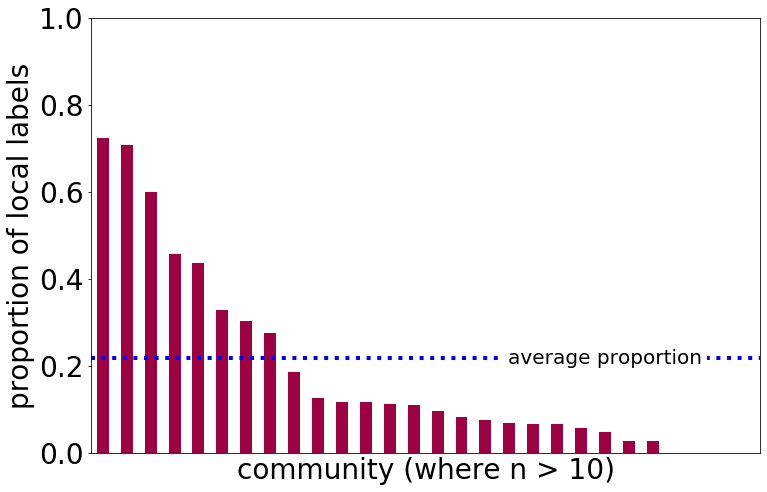

In [75]:
col = 'c_louvain_method'

s_lcl = df_comm.loc[df_comm['lcl_prf'] == True, col].value_counts()
s_total = df_comm.loc[df_comm['lcl_prf'].notna(), col].value_counts()
#s_total = df_comm[col].dropna().value_counts()

s_prop = s_lcl/s_total
s_prop = s_prop.fillna(0).sort_values(ascending=False)
s_prop = s_prop.loc[s_total > 10] # Only where community size > 10

ax = plt.axes()
exp_pos_proportion = df_comm.loc[df_comm['lcl_prf'] == True ].shape[0] / df_comm.loc[df_comm['lcl_prf'].notna()].shape[0]
ax.axhline(y=exp_pos_proportion, color='b', linestyle='dotted', lw=4)

s_prop.plot(kind='bar', colormap='Spectral', ax=ax)
plt.xticks([])
plt.xlabel('community label (where n > 10)')
plt.ylabel('proportion of local labels')

plt.ylim([0, 1])
plt.text(len(s_prop)*.75, exp_pos_proportion, 'average proportion', fontsize=20, va='center', ha='center', backgroundcolor='w')
#plt.legend()

#print(len(s_prop))

plt.savefig(LATEX_DIR + 'comm-lcl-prop-hrv.png', bbox_inches='tight')

In [67]:
# #from sklearn.feature_selection import chi2
# import pandas as pd
# import numpy as np
# from scipy.stats import chi2_contingency
# import seaborn as sns
# import matplotlib.pyplot as plt
# %matplotlib inline

# X = df_comm['c_louvain_method']
# y = df_comm['lcl_prf']

# contigency = pd.crosstab(X, y)
# contigency = pd.crosstab(X, y, normalize='index')

# # plt.figure(figsize=(12,8)) 
# # sns.heatmap(contigency, annot=True, cmap="YlGnBu")

### Chi Square

A chi-square test is used to test for a relationship between the 'local profile' label and assigned community, for each algorithm.

chi-square is a test for independence of different categories of a population. Therefore if p < 0.05, we believe variables are not independent. (reject null hypothesis of no relationship between variables).


In [7]:
# Chi Square test
# Returns dict of p-value per column
# Also Cramer's V -- test of strength of association

from scipy.stats import chi2_contingency

# From scipy 1.7, computes Cramer's V
# https://github.com/scipy/scipy/blob/v1.7.1/scipy/stats/contingency.py#L304-L402
from association import association


def lcl_comm_chi2(G, min_cell_v=5):
    nodes = G.nodes(data=True)
    df_comm = pd.DataFrame.from_dict(dict(nodes), orient='index')
    nodes = None

    results_dict = {}
    
    for col in df_comm.columns:
        if not col[:2] == 'c_':
            continue

        # Exclude communities below a certain size:
        # (No longer needed as cells <5 dropped later)
#         counts = df_comm[col].value_counts()
#         comms = counts[counts > 0].index
#         X = df_comm[df_comm[col].isin(comms)][col]
        
        # Get rows with non-null vals for both community and lcl_prf labels:
        sub_df = df_comm[df_comm[col].notna() & 
                         df_comm['lcl_prf'].notna()]
        X = sub_df[col]
        y = sub_df['lcl_prf']
        
        #X = df_comm[df_comm[col].notna()][col]

#         X = df_comm[col]
#         y = df_comm['lcl_prf']
        #y = df_comm[df_comm[col].notna()]['lcl_prf']
#         y = df_comm[df_comm[col].isin(comms)]['lcl_prf'] #Extra filtering may not be required
        
        # Drop nan lcl_prf vals:
        #X = X.loc[y.notna()]
        #y = y.loc[y.notna()]
        
        #contingency = pd.crosstab(X, y, normalize='index')
        contingency = pd.crosstab(X, y)

        # Remove rows where a cell has < 5 
        contingency = contingency.loc[(contingency[False] >= min_cell_v) & 
                                      (contingency[True] >= min_cell_v)]

        # Chi-square test of independence. 
        chi2, p, dof, expected = chi2_contingency(contingency)
        
        results_dict[col] = {'chi2': int(round(chi2)), 'p': round(p, 5),
                            'cramersV': association(contingency)}

    return results_dict

# Null hypothesis = variables are independent. 
# p < 0.05, so reject the null

In [10]:
print('p-val\tcrmrsV\talgorithm')
for k,v in lcl_comm_chi2(G).items():
    print('{}\t{:.2f}\t{}'.format(v['p'], v['cramersV'], k))

p-val	crmrsV	algorithm
0.0	0.66	c_label_propogation
0.0	0.19	c_label_prop_asyn
0.0	0.51	c_fluid
0.0	0.65	c_louvain_method


### Florence

In [11]:
G = nx.read_gexf(FLR_GEXF)

nodes = G.nodes(data=True)
df_comm = pd.DataFrame.from_dict(dict(nodes), orient='index')
nodes = None

df_comm.head()

,screen_name,user_class,user_id,ratio_original,ratio_detected,ratio_media,tweets_per_hour,top_source,data_source,verified,statuses_count,favourites_count,followers_count,friends_count,lcl_prf,label
1000001222714126336,KKnight1994,2,1000001222714126336,1.0,1.0,0.000000,0.005952,Twitter Web Client,1,False,26,1,19,30,NaN,1000001222714126336
1000013516147916800,SummerLoving31,2,1000013516147916800,1.0,1.0,0.000000,0.005952,Twitter Lite,1,False,531,0,22,127,False,1000013516147916800
1000026906186543105,Langitblue122,2,1000026906186543105,1.0,1.0,0.000000,0.011905,Twitter Web Client,1,False,2017,12,10,126,NaN,1000026906186543105
1000034146251608065,teamtropicstorm,2,1000034146251608065,1.0,1.0,0.666667,0.017857,IFTTT,1,False,252,5,300,13,False,1000034146251608065
1000046340557156353,FKosgalwies,2,1000046340557156353,1.0,1.0,0.000000,0.005952,Twitter Web Client,1,False,1071,52,588,1730,NaN,1000046340557156353


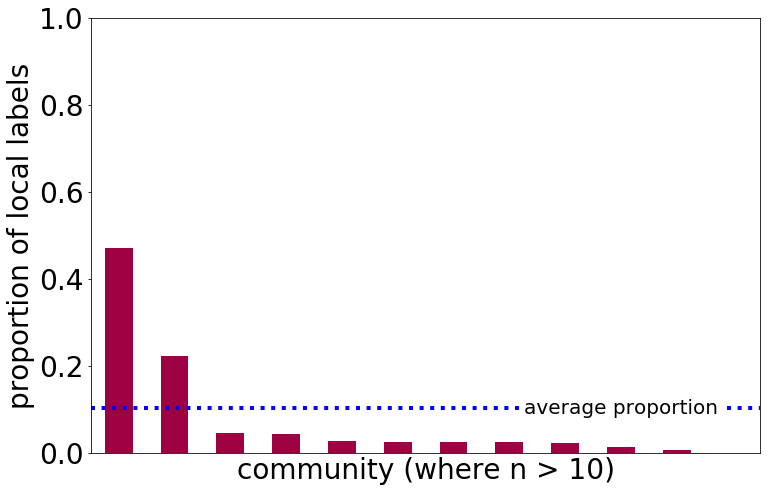

In [9]:
col = 'c_louvain_method'

s_lcl = df_comm.loc[df_comm['lcl_prf'] == True, col].value_counts()
s_total = df_comm.loc[df_comm['lcl_prf'].notna(), col].value_counts()
#s_total = df_comm[col].dropna().value_counts()

s_prop = s_lcl/s_total
s_prop = s_prop.fillna(0).sort_values(ascending=False)
s_prop = s_prop.loc[s_total > 10] # Only where community size > 10

ax = plt.axes()
exp_pos_proportion = sum(df_comm['lcl_prf'] == True) / sum(df_comm['lcl_prf'].notna())
ax.axhline(y=exp_pos_proportion, color='b', linestyle='dotted', lw=4)

s_prop.plot(kind='bar', colormap='Spectral', ax=ax)
plt.xticks([])
plt.xlabel('community label (where n > 10)')
plt.ylabel('proportion of local labels')

plt.ylim([0, 1])
plt.text(len(s_prop)*.75, exp_pos_proportion, 'average proportion', fontsize=20, va='center', ha='center', backgroundcolor='w')

plt.savefig(LATEX_DIR + 'comm-lcl-prop-flr.png', bbox_inches='tight')

In [29]:
# from scipy.stats import chi2_contingency

# nodes = G.nodes(data=True)
# df_comm = pd.DataFrame.from_dict(dict(nodes), orient='index')
# nodes = None

# for col in df_comm.columns:
#     if not col[:2] == 'c_':
#         continue

#     # Exclude communities below a certain size:
#     counts = df_comm[col].value_counts()
#     comms = counts[counts > 10].index
#     X = df_comm[df_comm[col].isin(comms)][col]

#     #X = df_comm[col]
# #    y = df_comm['lcl_prf']
#     y = df_comm['lcl_prf']

#     # Drop nan lcl_profile vals:
#     #X = X.loc[y != '']
#     y = y.loc[y != '']

#     contigency = pd.crosstab(X, y, normalize='index')

#     # Chi-square test of independence. 
#     c, p, dof, expected = chi2_contingency(contigency) 
#     print('{:.4f} {}'.format(p, col))

# # Null hypothesis = variables are independent. < 0.05, so reject the null

print('p-val\tcrmrsV\talgorithm')
for k,v in lcl_comm_chi2(G).items():
    print('{}\t{:.2f}\t{}'.format(v['p'], v['cramersV'], k))

p-val	crmrsV	algorithm
0.0	0.14	c_label_propogation
0.0	0.55	c_label_prop_asyn
0.0	0.59	c_fluid
0.0	0.51	c_louvain_method


## Comparing Community Algorithm Performance

Testing the extent to which each algorithm creates communities specific to local- or non-locally-labelled nodes. That is, which algorithm shows the most promise in generating useful labels for locality prediction.

### Harvey

In [7]:
from networkx.algorithms.cluster import average_clustering
from networkx.algorithms.assortativity import degree_assortativity_coefficient

def get_community_props(G):
    df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
    algorithms = [col for col in df.columns if col[:2] == 'c_']

    comms_dict = {}

    for algorithm in algorithms:
        counts = df[algorithm].value_counts()
        communities = counts.index
        comm_dict = {}

        for comm in communities:
            comm_nodes = [node for node, data in G.nodes(data=True) if data.get(algorithm) == comm]
            G_s = G.subgraph(comm_nodes)
            # Make undirected
            G_s = nx.Graph(G_s)

            df_s = df.loc[df.index.isin(comm_nodes)]
#             if len(df_s.loc[df_s['lcl_prf']!='']) > 0:
            if sum(df_s['lcl_prf'].isna() == False) > 0:
#                 lcl_prop = len(df_s.loc[df_s['lcl_prf']=='true']) / len(df_s.loc[df_s['lcl_prf']!=''])
                lcl_prop = sum(df_s['lcl_prf'] == True) / sum(df_s['lcl_prf'].notna())
            else: # No positive labels in community
                lcl_prop = 0

            cent_deg = nx.degree_centrality(G_s)
            cent_deg = sum(cent_deg.values())/len(cent_deg)
            cent_eigen = nx.eigenvector_centrality(G_s, max_iter=10000)
            cent_eigen = sum(cent_eigen.values())/len(cent_eigen)
        #     cent_bet = nx.betweenness_centrality(G_s)
        #     cent_bet = sum(cent_bet.values())/len(cent_bet)
        #     cent_close = nx.closeness_centrality(G_s)
        #     cent_close = sum(cent_close.values())/len(cent_close)
            # assort_deg fails for small graphs (1-2 nodes):
            try:
                assort_deg = degree_assortativity_coefficient(G_s)
            except:
                assort_deg = None
            clustering = average_clustering(G_s)
            avg_deg = 2*G_s.number_of_edges() / float(G_s.number_of_nodes())

            comm_dict[comm] = {'size': len(comm_nodes), 'lcl_prop': lcl_prop, 'avg_cent_deg':cent_deg, 'avg_cent_eigen':cent_eigen,
        #                       'cent_bet':cent_bet, 'cent_close':cent_close, 
                               'assort_deg':assort_deg, 'clustering':clustering, 'avg_deg':avg_deg}

        comms_dict[algorithm] = comm_dict
    return comms_dict

In [8]:
from scipy import stats

def get_correlations(df, cols, y_label):
    results_dict = {}

    for col in cols:
        df_b = df.copy()
        df_b = df_b.loc[df_b[col].isna()==False].loc[df_b[y_label].isna()==False]
        # Balancing dataset:
    #     g = df_b.groupby(y_label)
    #     df_b = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
        a = list(df_b[y_label])
        b = list(df_b[col])
        pb = stats.pointbiserialr(a, b)
        rho = stats.spearmanr(a, b)
        #print(col, stats.spearmanr(a, b), stats.pointbiserialr(a, b))
        results_dict[col] = {'r_pb':pb[0], 'p_pb':pb[1], 'r_rho':rho[0], 'p_rho':rho[1]}
    return results_dict

In [40]:
G = nx.read_gexf(HRV_GEXF)

df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

#df['lcl_prf'] = df['lcl_prf'].map(str_to_bool)

algorithms = [col for col in df.columns if col[:2] == 'c_']

df.head()

,screen_name,user_class,added_at,c_label_propogation,c_label_prop_asyn,c_fluid,c_louvain_method,label,lcl_prf,user_code
1000161164,edmesaaz,2,2017-08-31 04:10:12.701461+00:00,NaN,NaN,NaN,NaN,1000161164,NaN,NaN
100039898,SwiiFFtAyala,2,2017-08-30 02:56:05.551143+00:00,NaN,NaN,NaN,NaN,100039898,False,NaN
1000520550,TheGlenBird,2,2017-08-26 01:24:44.503526+00:00,NaN,NaN,NaN,NaN,1000520550,False,NaN
1000636034,1oakmoma,2,2017-08-26 18:58:51.027465+00:00,2.0,0.0,25.0,8.0,1000636034,False,NaN
1000653007,ShansPLM,2,2017-09-02 03:02:09.937624+00:00,NaN,NaN,NaN,NaN,1000653007,False,NaN


In [41]:
# Create columns describing proportion of local nodes in community, add for each nodes assigned community

hrv_comms_dict = get_community_props(G)

for alg in algorithms:
    prop_dict = {k:v['lcl_prop'] for k, v in hrv_comms_dict[alg].items()}
    df[alg + '_prop'] = df[alg].map(prop_dict)

/home/rosles/projects/crisis-data/venv/lib/python3.6/site-packages/networkx/algorithms/assortativity/correlation.py:287: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / numpy.sqrt(vara * varb)


In [42]:
# Calculate correlation between node locality and the community in which they are a member

cols = [alg + '_prop' for alg in algorithms]
results_dict = get_correlations(df, cols, 'lcl_prf')

for key in list(results_dict.keys()):
    results_dict[key[2:-5]] = results_dict.pop(key)

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df = results_df.reset_index()
results_df = results_df.rename(columns = {'index':'Algorithm'})
results_df = results_df.rename(columns = {'r_pb':'r_pb_harvey', 'p_pb':'p_pb_harvey', 'r_rho':'r_rho_harvey', 'p_rho':'p_rho_harvey'})
results_df

,Algorithm,r_pb_harvey,p_pb_harvey,r_rho_harvey,p_rho_harvey
0,fluid,0.517079,0.0,0.486901,0.0
1,label_prop_asyn,0.394554,0.0,0.365172,0.0
2,label_propogation,0.716333,0.0,0.639197,0.0
3,louvain_method,0.649225,0.0,0.559946,0.0


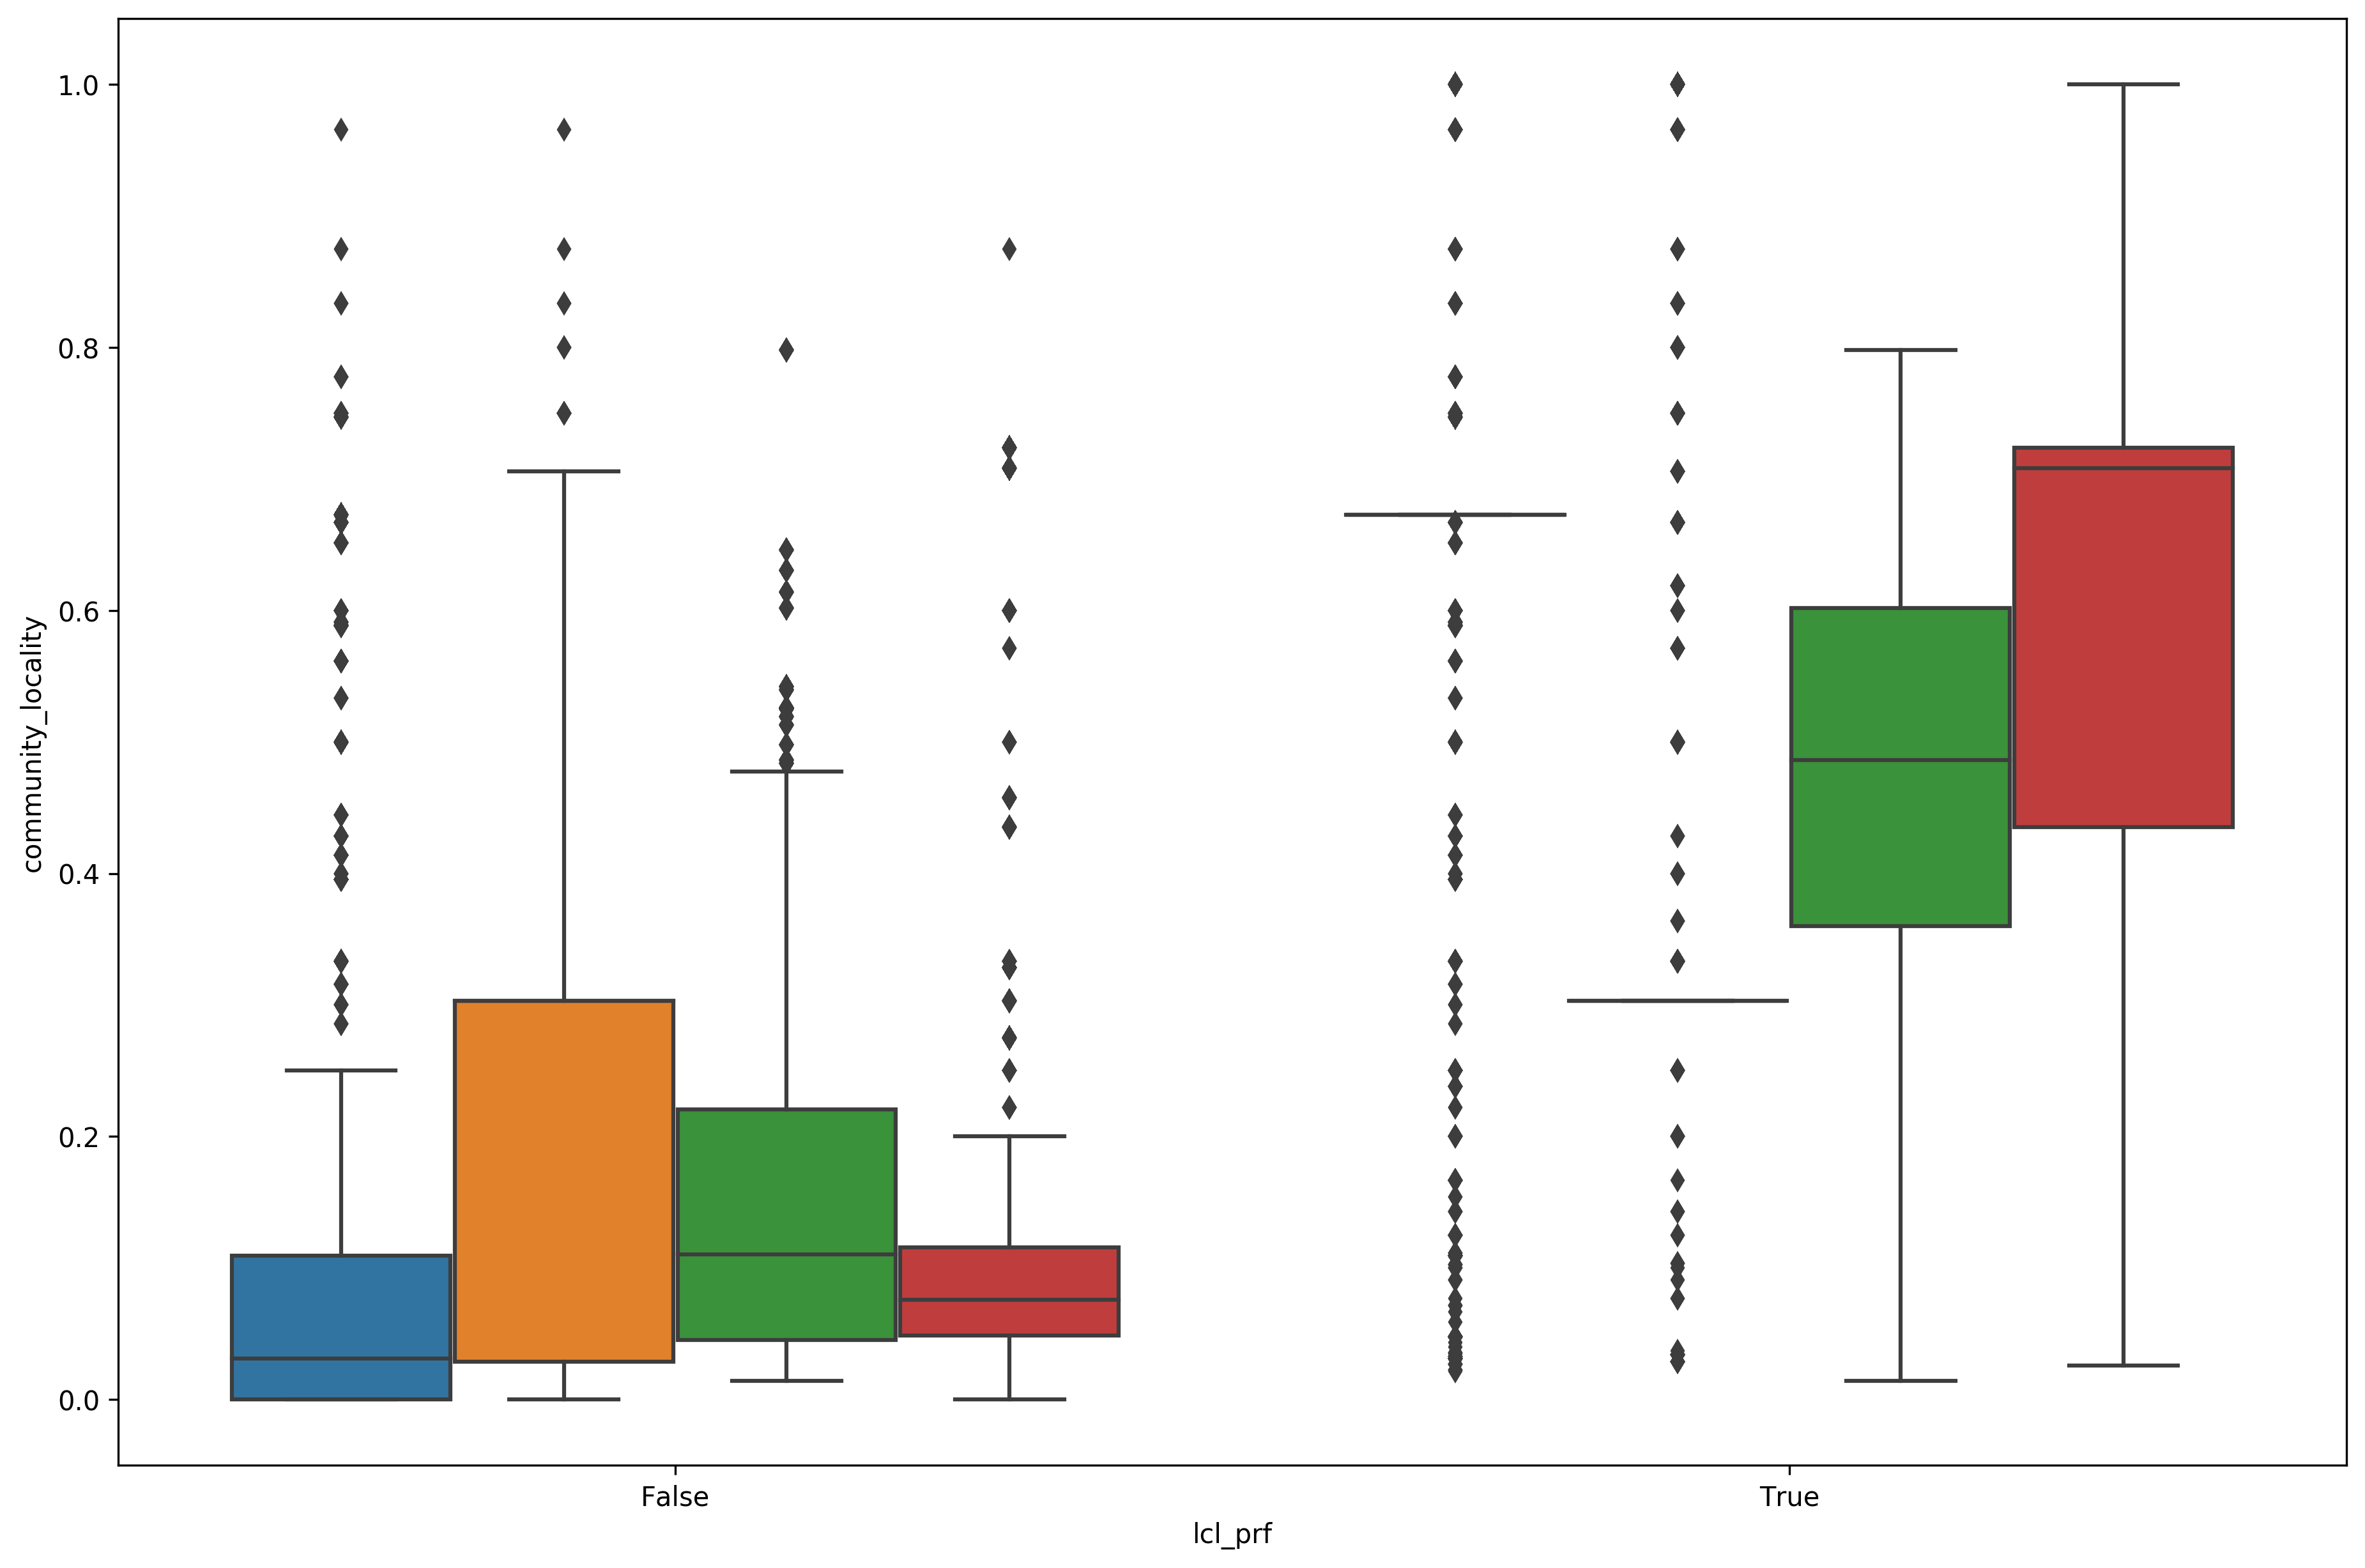

In [43]:
#https://stackoverflow.com/questions/16592222/matplotlib-group-boxplots
# Note that the boxes are affected by the limited number of communities and therefore prop values.

# df[['lcl_prf']+[x + '_prop' for x in algorithms]].boxplot(by='lcl_prf')
# plt.savefig(LATEX_DIR + 'boxplot-hrv.png', bbox_inches='tight')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize = (15, 10), dpi=300)

dd = pd.melt(df.loc[df['lcl_prf'].isna()==False], id_vars=['lcl_prf'], value_vars=[x + '_prop' for x in algorithms], var_name='algorithms')
dd = dd.rename(columns={'value':'community_locality'})

sns.boxplot(x='lcl_prf', y='community_locality', data=dd, hue='algorithms')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend([],[], frameon=False) # hide legend as it is added on Florence image

#plt.yticks([])
#ax.set_ylabel('') 

plt.savefig(LATEX_DIR + 'comm-boxplot-hrv.png', bbox_inches='tight')

In [44]:
# # Check that legend matches Florence below:

# fig, ax = plt.subplots(1, 1, figsize = (8, 6), dpi=150)

# dd = pd.melt(df.loc[df['lcl_prf'].isna()==False], id_vars=['lcl_prf'], value_vars=[x + '_prop' for x in algorithms], var_name='algorithms')
# dd = dd.rename(columns={'value':'community_locality'})

# sns.boxplot(x='lcl_prf', y='community_locality', data=dd, hue='algorithms')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Florence

In [45]:
G = nx.read_gexf(FLR_GEXF)
df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
algorithms = [col for col in df.columns if col[:2] == 'c_']

flr_comms_dict = get_community_props(G)
for alg in algorithms:
    prop_dict = {k:v['lcl_prop'] for k, v in flr_comms_dict[alg].items()}
    df[alg + '_prop'] = df[alg].map(prop_dict)

cols = [alg + '_prop' for alg in algorithms]
results_dict = get_correlations(df, cols, 'lcl_prf')

for key in list(results_dict.keys()):
    results_dict[key[2:-5]] = results_dict.pop(key)

/home/rosles/projects/crisis-data/venv/lib/python3.6/site-packages/networkx/algorithms/assortativity/correlation.py:287: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / numpy.sqrt(vara * varb)


In [46]:
results_df2 = pd.DataFrame.from_dict(results_dict, orient='index')
results_df2 = results_df2.reset_index()
results_df2 = results_df2.rename(columns = {'index':'Algorithm'})
results_df2 = results_df2.rename(columns = {'r_pb':'r_pb_florence', 'p_pb':'p_pb_florence', 
                                            'r_rho':'r_rho_florence', 'p_rho':'p_rho_florence'})

results_df['r_pb_florence'] = results_df2['r_pb_florence']
results_df['p_pb_florence'] = results_df2['p_pb_florence']
results_df['r_rho_florence'] = results_df2['r_rho_florence']
results_df['p_rho_florence'] = results_df2['p_rho_florence']
results_df

,Algorithm,r_pb_harvey,p_pb_harvey,r_rho_harvey,p_rho_harvey,r_pb_florence,p_pb_florence,r_rho_florence,p_rho_florence
0,fluid,0.517079,0.0,0.486901,0.0,0.594868,0.0,0.392669,0.000000e+00
1,label_prop_asyn,0.394554,0.0,0.365172,0.0,0.560541,0.0,0.388306,0.000000e+00
2,label_propogation,0.716333,0.0,0.639197,0.0,0.167529,0.0,0.137470,4.586552e-261
3,louvain_method,0.649225,0.0,0.559946,0.0,0.509981,0.0,0.392975,0.000000e+00


In [47]:
## Writing to TEX:

# Drop p-val columns, as uninformative
results_df.drop(columns = [col for col in results_df.columns if col[:2] == 'p_'], inplace=True)
# Round to 3 decimal places
dec_dict = {col:3 for col in results_df.columns if col[:2] == 'r_'}
width = 1
caption='Point-biserial and Spearman\'s rho correlation coefficient for variables node locality and community locality.'

### If using only one measure, rename columns and select sub-df. e.g.: ###
# col_renames = {'r_pb_harvey':'r_harvey', 'r_pb_florence':'r_florence'}
# results_df = results_df.rename(columns = col_renames)
# width = 0.6
# caption='Point-biserial correlation coefficient for variables node locality and community locality'
# df_to_tex(results_df[['Algorithm'] + list(col_renames.values())], label='alg-corr', 

df_to_tex(results_df, label='alg-corr', caption=caption, width=width, dec_dict=dec_dict)

Writing df to file as tex...


In [48]:
# alg = 'c_louvain_method'

# for alg in algorithms:
#     alg += '_prop'
#     df_b = df[['lcl_prf', alg]]
#     df_b = df_b.loc[df_b[alg].isna()==False].loc[df_b['lcl_prf'].isna()==False]

#     x1 = df_b.loc[df_b['lcl_prf'] == False][alg]
#     x2 = df_b.loc[df_b['lcl_prf'] == True][alg]

#     plt.boxplot ([x1, x2])
    
#     #df_b.boxplot(by='lcl_prf')

# #df_b.boxplot(by='lcl_prf')

# df[['lcl_prf']+[x + '_prop' for x in algorithms]].boxplot(by='lcl_prf')

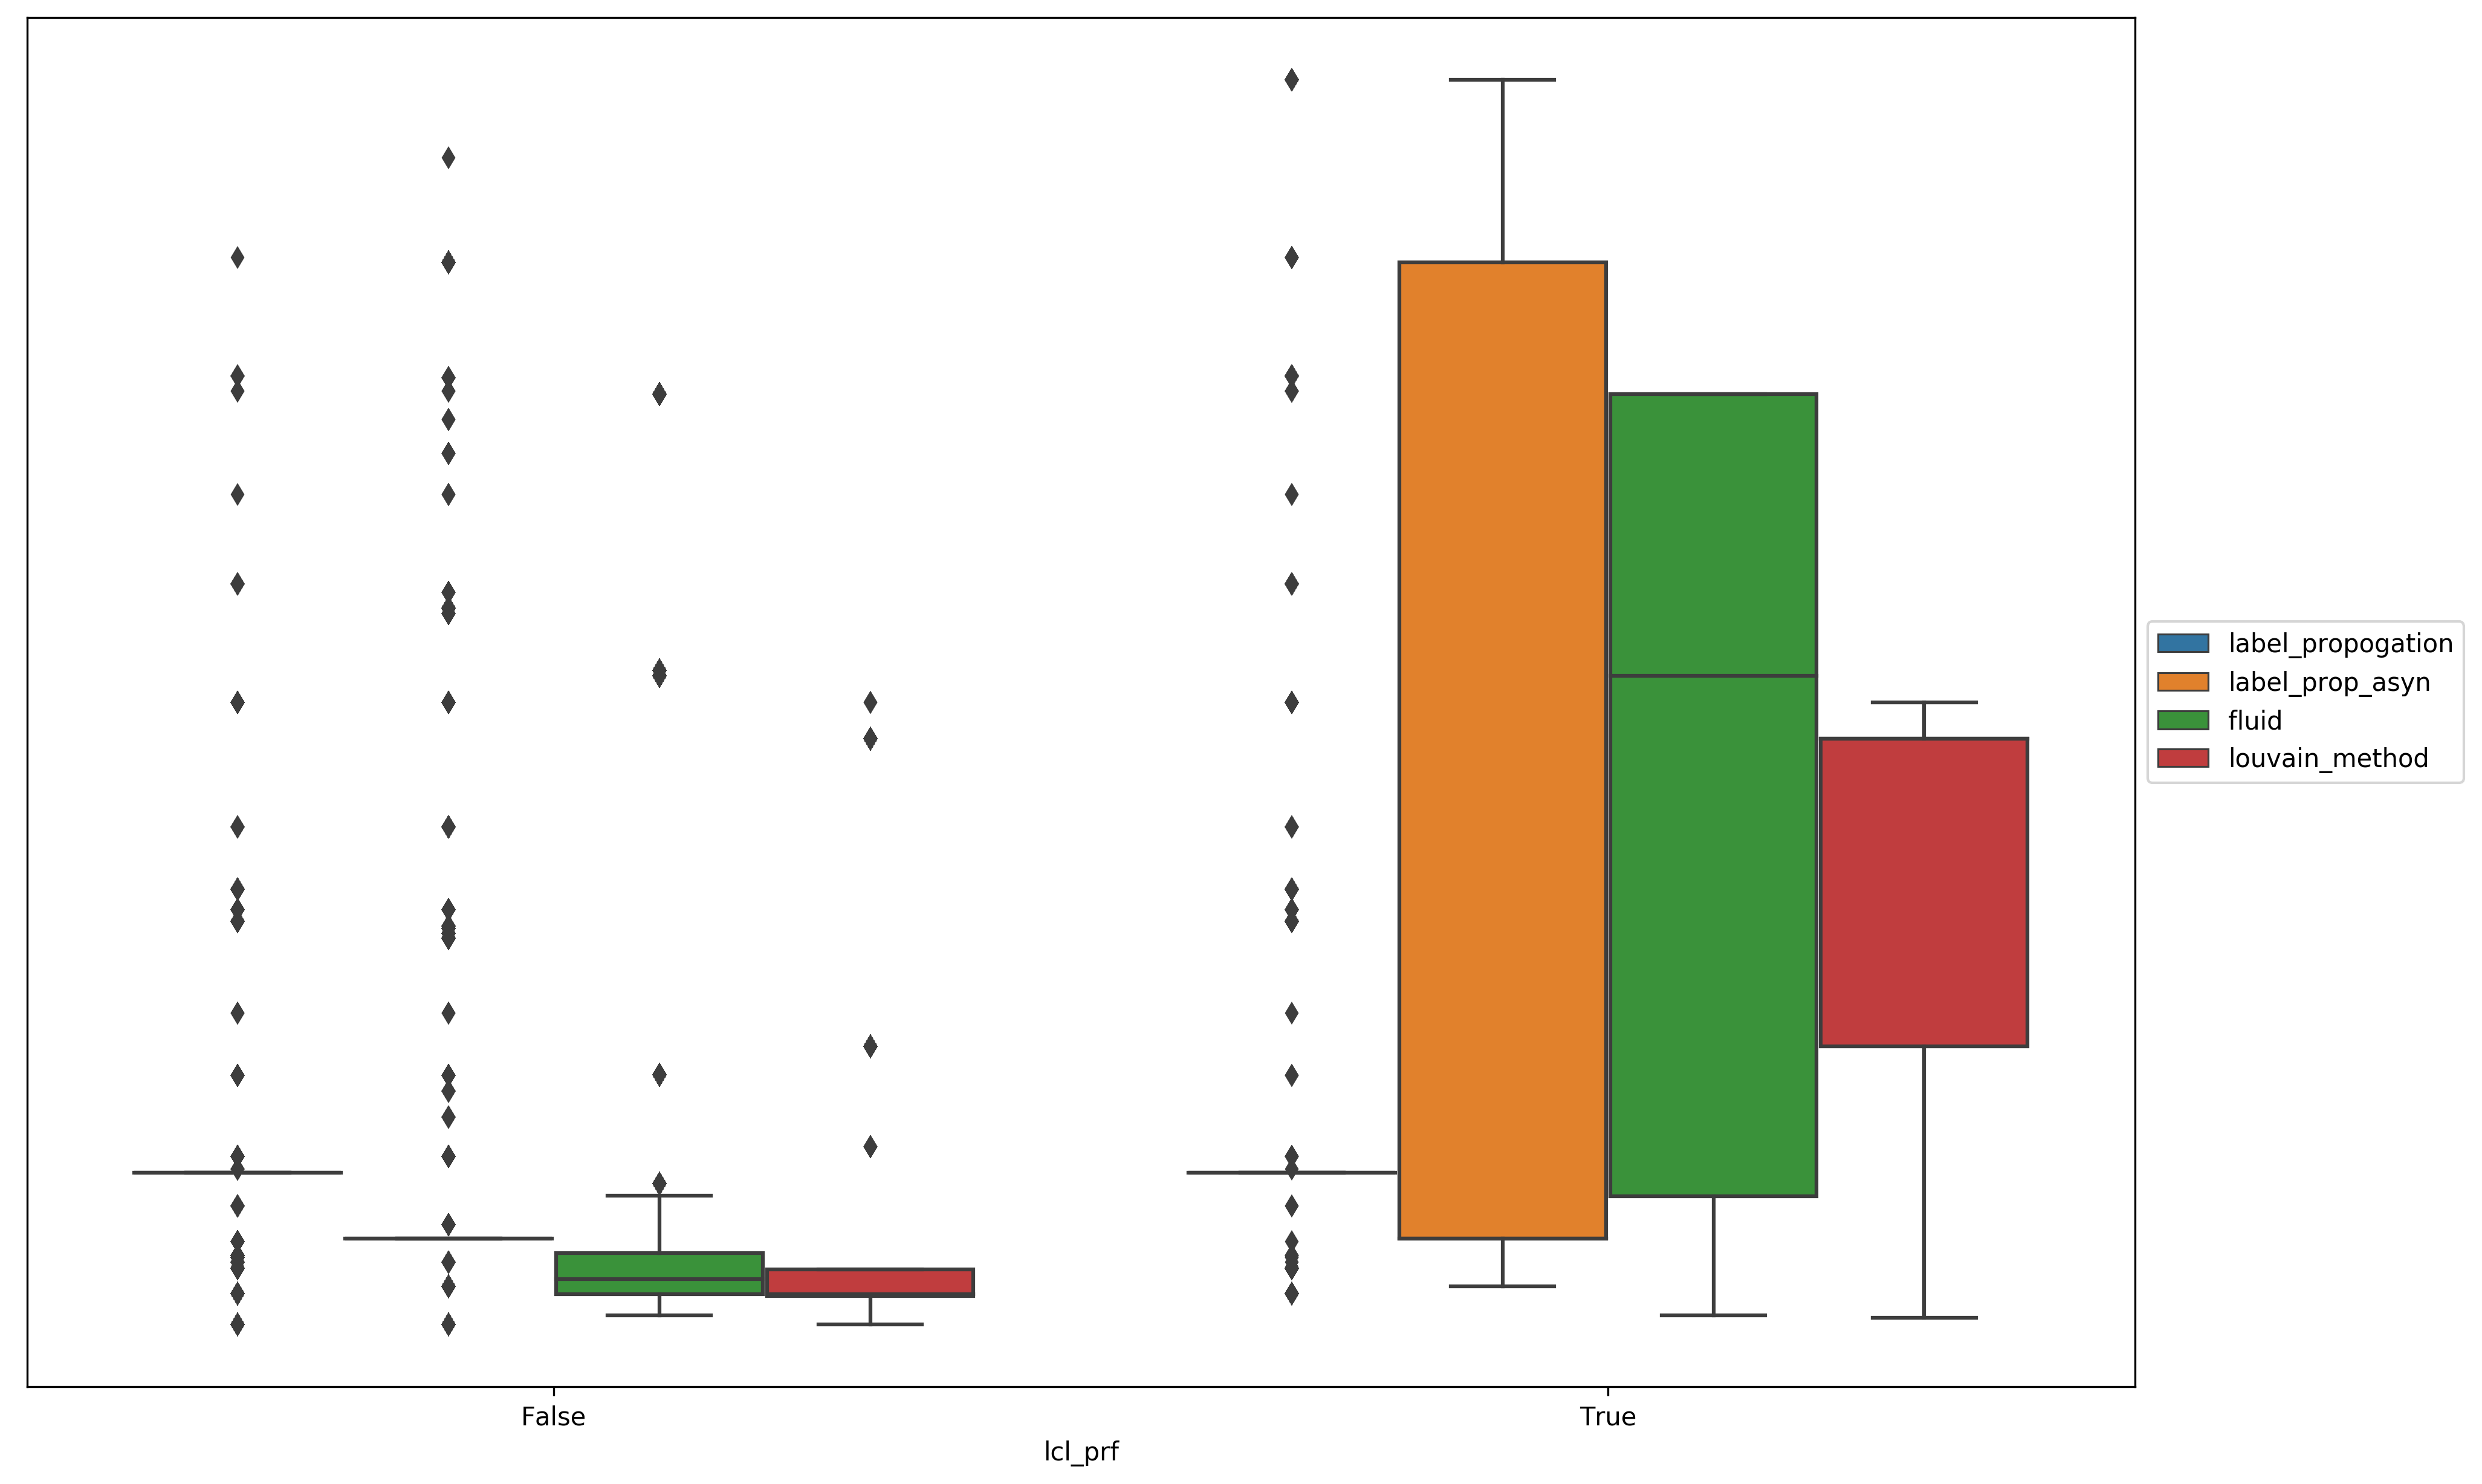

In [49]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize = (15, 10), dpi=300)

# Remove leading c_ and 'prop' for the legend
prop_cols = [x + '_prop' for x in algorithms]
alg_rename_dict = {x:x[2:-5] for x in prop_cols}
df_b = df.loc[df['lcl_prf'].isna()==False][['lcl_prf']+prop_cols]
df_b = df_b.rename(columns=alg_rename_dict)

dd = pd.melt(df_b, id_vars=['lcl_prf'], value_vars=alg_rename_dict.values(), var_name='algorithms')
dd = dd.rename(columns={'value':'community_locality'})

sns.boxplot(x='lcl_prf', y='community_locality', data=dd, hue='algorithms')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.legend([],[], frameon=False)

plt.yticks([])
ax.set_ylabel('') 

plt.savefig(LATEX_DIR + 'comm-boxplot-flr.png', bbox_inches='tight')

In [50]:
# Save relative proportions of two boxplots to variables to allow latex to set appropriate widths
# (as the legend elongates the second image)

from PIL import Image

filepath = LATEX_DIR + 'comm-boxplot-hrv.png'
img = Image.open(filepath)
w1 = img.width

filepath = LATEX_DIR + 'comm-boxplot-flr.png'
img = Image.open(filepath)
w2 = img.width

set_tex_var('boxplotWidthHrv', 1/(w1+w2)*w1, 5)
set_tex_var('boxplotWidthFlr', 1/(w1+w2)*w2, 5)

## Comparing Community Metrics and Locality
Compute correlation between the locality of a community (as the proportion of local to non-local nodes) and the labels of nodes within the community. Note that this, by definition, must be positive, so the interest is on the strength of the correlation across different community algorithms.

Test communities to see whether more local communities are, for example, more connected. Visual results show little correlation, so this was not pursued.

The network structures of the sub communities (as defined by the louvain algorithm) were characterised using the metrics: degree centrality, eigenvector centrality, degree assortativity coefficient, average clustering coefficient, avg degree, size. Correlations between these metrics and their community locality proportions were then tested using Spearmans Rho. For each set of metrics for both event networks, no significant correlation was found between these community structure descriptors and the proportion of local nodes they contain. While such a relationship may yet exist (and indeed, intuition suggests that it does), it may be obscured by the imperfect classification provided by the community detection algorithm or incorrect selection of characterisation metrics and therefore warrants further research.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f45c1d652e8>,
      dtype=object)

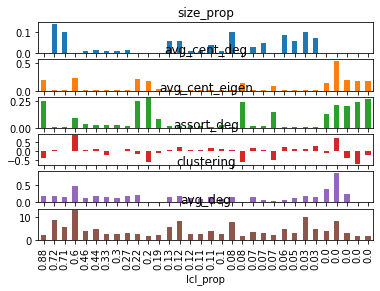

In [51]:
# Test various metics for correlation with proportion of local nodes,
# Plot the values calculated above, sorted by proportion of local profiles:

df_test = pd.DataFrame.from_dict(hrv_comms_dict['c_louvain_method'], orient='index')

# Ignore comms below size:
df_test = df_test.loc[df_test['size'] > 10]
df_test['lcl_prop'] = df_test['lcl_prop'].round(2)
df_test['size_prop'] = (df_test['size'] / df_test['size'].sum()).round(4)
df_test = df_test.sort_values('lcl_prop', ascending=False)

cols = df_test.columns[2:]
y_label = 'lcl_prop'
hrv_corr_dict = get_correlations(df_test, cols, y_label)

df_test[['size_prop', 'lcl_prop', 'avg_cent_deg', 'avg_cent_eigen', 
#          'cent_bet', 'cent_close',
        'assort_deg', 'clustering', 'avg_deg']].plot(kind='bar', subplots=True, legend=False, x='lcl_prop')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f45c1d8deb8>,
      dtype=object)

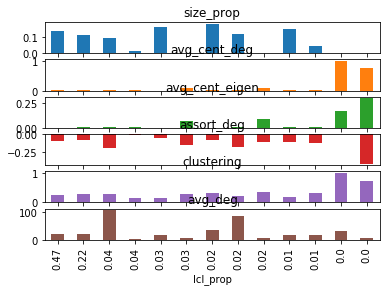

In [52]:
# Repeeat above, for Florence network:
  
df_test = pd.DataFrame.from_dict(flr_comms_dict['c_louvain_method'], orient='index')

# Ignore comms below size:
df_test = df_test.loc[df_test['size'] > 10]
df_test['lcl_prop'] = df_test['lcl_prop'].round(2)
df_test['size_prop'] = (df_test['size'] / df_test['size'].sum()).round(4)
df_test = df_test.sort_values('lcl_prop', ascending=False)

cols = df_test.columns[2:]
y_label = 'lcl_prop'
flr_corr_dict = get_correlations(df_test, cols, y_label)

df_test[['size_prop', 'lcl_prop', 'avg_cent_deg', 'avg_cent_eigen', 
#          'cent_bet', 'cent_close',
        'assort_deg', 'clustering', 'avg_deg']].plot(kind='bar', subplots=True, legend=False, x='lcl_prop')

In [53]:
corr_df = pd.DataFrame.from_dict(hrv_corr_dict, orient='index')[['r_rho', 'p_rho']]
corr_df2 = pd.DataFrame.from_dict(flr_corr_dict, orient='index')[['r_rho', 'p_rho']]

corr_df = corr_df.rename(columns = {'r_rho':'r_rho_harvey', 'p_rho':'p_rho_harvey'})
corr_df['r_rho_flr'] = corr_df2['r_rho']
corr_df['p_rho_flr'] = corr_df2['p_rho']

corr_df = corr_df.reset_index()
corr_df = corr_df.rename(columns = {'index':'Metric'})

corr_df

,Metric,r_rho_harvey,p_rho_harvey,r_rho_flr,p_rho_flr
0,assort_deg,-0.043550,0.812914,0.438972,0.153389
1,avg_cent_deg,-0.006248,0.972925,-0.444472,0.128083
2,avg_cent_eigen,-0.057516,0.754529,-0.511143,0.074227
3,avg_deg,0.058445,0.750686,0.036113,0.906761
4,clustering,0.159057,0.384562,-0.552812,0.050066
5,size_prop,0.092664,0.613966,0.361133,0.225384


In [54]:
## Writing to TEX:

# Drop p-val columns, as uninformative
#results_df.drop(columns = [col for col in results_df.columns if col[:2] == 'p_'], inplace=True)
# Round to 3 decimal places
dec_dict = {col:3 for col in corr_df.columns[1:]}
width = 0.8
caption='Spearman\'s rho correlation coefficient for various community metric variables and community locality.'

df_to_tex(corr_df, label='comm-metrics-corr', caption=caption, width=width, dec_dict=dec_dict)

Writing df to file as tex...


## Evaluating Networks at Earlier Times

The method of locality prediction proposed by this section was shown to be effective on 'mature' networks -- that is, the state of the network after several days of data collection. For the purpose proposed by this work, classification must occur in a live environment and therefore take a less complete graph object as input. The extent to which the smaller datasets (as they exist at earlier intervals) impacts the predictive power of the community detection method was therefore evaluated to test the applicability of the method to live scenarios with evolving input graphs.

In [9]:
import networkx as nx
from datetime import datetime, timedelta
import pandas as pd


def str_to_date(date_str):
    return datetime.strptime(date_str[:-6], '%Y-%m-%d %H:%M:%S.%f') + timedelta(days=1)


def get_graph_objects_time_sliced(G, block_hours = 24, FILENAME = None, OVERWRITE = False):
    """
    Creates subgraphs of the main event's graph every 
    block_hours hours from start date.
    
    Sub-graphs are processed within the function to avoid
    overflow when holding multiple G objects in memory.
    
    Returns a DataFrame of metrics for each G, keyed by the time
    t hours of cutoff.
    """
    
    # This must match format returned from get_g_summary_row
    T0_ROW = [0]*6 + [None]*4
    
    # Calculate duration of event:
    start = str_to_date(min(nx.get_node_attributes(G,'added_at').values()))
    end = str_to_date(max(nx.get_node_attributes(G,'added_at').values()))
    # Number of blocks of length block_hours in event duration:
    duration_blocks = (end - start).total_seconds()/3600/block_hours
    # Create timestamps every block_hours period:
    time_slices = [start + timedelta(hours = (t+1)*block_hours) for t in range(int(duration_blocks))]

    df_dict = {}
    
    # Create subgraphs for each time stamp and get metrics as dict entry
    for i in range(len(time_slices)):
        print('Creating time slice {} of {}...'.format(i+1, int(duration_blocks)))
        # Subset of nodes added prior to slice point:
        partition = [node for node, data in G.nodes(data=True) if 
                        str_to_date(data.get('added_at')) < time_slices[i]]        
        # Create copy so that attributes aren't deleted from main G
        G_sub = G.subgraph(partition).copy()
        # Delete community metrics if copied in from original Graph:
        df = pd.DataFrame.from_dict(dict(G_sub.nodes(data=True)), orient='index')
        algorithms = [col for col in df.columns if col[:2] == 'c_']
        for node in G_sub.nodes:
            for alg in algorithms:
                try:
                    del G_sub.nodes[node][alg]
                except:
                    pass
        # Calculate metrics and community values for G_sub:
        k = (i+1)*block_hours
        df_dict[k] = get_g_summary_row(G_sub, k, FILENAME, OVERWRITE)

    print("Blocks are {} hours. {:.2f} hours between last subgraph and end time ({:.0f}% of a block).".format(
        block_hours, duration_blocks%1*block_hours, duration_blocks%1*100))
    
    # Add final G at end:
    df_dict[round((duration_blocks*block_hours), 1)] = get_g_summary_row(G, FILENAME, OVERWRITE)
    
    dft = pd.DataFrame.from_dict(df_dict, orient='index')
    # Add t=0 row:
    dft.loc[0] = T0_ROW
    dft.sort_index(inplace=True)
    
    return dft

Then run same analysis on subgraphs to see whether patterns emerge at earlier points:

In [10]:
'''
This function repeats the steps covered in the analysis above
for a set of graphs passed in as a dictionary. The purpose being
to analyse a set of sub-graphs drawn from an original graph object.

Currently calculates community metrics for all algorithms, but 
only uses louvain_method for correlation measures.

G_dict: dictionary of graph objects to be analysed
FILENAME: path and filename of original G, if provided, 
subgraphs will be written to disk to preserve community calculations.

Returns a dictionary of summary dataframes keyed by timeslice index.

TODO: Write node values to file as JSON rather than entire G object?
'''
# def process_t_subgraphs(G_dict: dict, FILENAME=None, OVERWRITE=False):
#     # Dict containing dataframe for each Gt
#     df_dict = {}
#     c = 1
#     for k, Gt in G_dict.items():
#         print('Running Gt {} of {}'.format(c, len(G_dict)))
#         c += 1
#         df_dict[k] = get_g_summary_row(Gt, k, FILENAME, OVERWRITE)
#     return df_dict


def get_g_summary_row(Gt, k, FILENAME=None, OVERWRITE=False):
    row_dict = {}

    ###########################
    row_dict['nodes_total'] = Gt.number_of_nodes()
    row_dict['edges_total'] = Gt.number_of_edges()
    # LCC size:
    Gt_c = nx.Graph(Gt)
    Gcc = max(nx.connected_components(Gt_c), key=len)
    Gt_c = Gt_c.subgraph(Gcc)
    row_dict['nodes_lcc'] = Gt_c.number_of_nodes()
    row_dict['edges_lcc'] = Gt_c.number_of_edges()
    # Geocoded G size:
    partition = [node for node, data in Gt.nodes(data=True) if data.get('lcl_prf') in [True, False]]
    Gt_p = Gt.subgraph(partition)
    row_dict['nodes_geocoded'] = Gt_p.number_of_nodes()
    row_dict['edges_geocoded'] = Gt_p.number_of_edges()
    # 'Assortativity for non-null profile location nodes, directed':
    assort_coef = nx.attribute_assortativity_coefficient(Gt_p, 'lcl_prf')
    row_dict['lcl_prf_assort'] = assort_coef

    ###########################
    # Calculate new community values.
    # If FILENAME is passed, write subgraphs to new files.
    # Skip community calculation if c_louvain_method attr exists or G is final:
    if not nx.get_node_attributes(Gt,'c_louvain_method'):
        if FILENAME:
            T_FILENAME = FILENAME[:-5] + '_tSlice' + str(k) + FILENAME[-5:]
        if FILENAME and OVERWRITE:
            try:
                os.remove(T_FILENAME)
            except:
                pass
        try:
            Gt = nx.read_gexf(T_FILENAME)
            print('Importing existing Gt file...')
        except:
            print("Calculating community metrics...")
            Gt = calc_community_metrics(Gt)
            if FILENAME:
                print('Writing Gt to file...')
                nx.write_gexf(Gt, T_FILENAME, prettyprint=True)
    else:
        print('Existing c_louvain_method attributes detected..')

    ###########################
    # Assortativity by community label
    dft = get_comm_summary_df(Gt)
    louvain_assort = dft.loc['louvain_method']['Assortativity Coefficient']
    row_dict['louvain_assort'] = louvain_assort

    ###########################
    # Run config models to calculate significance of assortativity:
    #config_assort_avg = calc_config_assort(Gt, N_SIMULATIONS)
    #dft.insert(loc=2, column="Avg. Configuration Model Assortativity", value=config_assort_avg)
    # TBC..

    ###########################
    # Test for relationship between community label and locality using chi2:    
    chi2_res = lcl_comm_chi2(Gt)['c_louvain_method']
    row_dict['chi2'] = chi2_res['chi2']
    row_dict['p_chi2'] = chi2_res['p']

    ###########################
    # Correlation between community locality proportion and node locality value
    #########
    ######### Not useful, don't use ! #########
    ######### Only useful for comparing alg performance in comm allocation,
#         df = pd.DataFrame.from_dict(dict(Gt.nodes(data=True)), orient='index')
#         algorithms = ['c_louvain_method']

#         Gt_comms_dict = get_community_props(Gt)

#         for alg in algorithms:
#             prop_dict = {k:v['lcl_prop'] for k, v in Gt_comms_dict[alg].items()}
#             df[alg + '_prop'] = df[alg].map(prop_dict)

#         # Calculate correlation between node locality and the community in which they are a member
#         cols = [alg + '_prop' for alg in algorithms]
#         results_dict = get_correlations(df, cols, 'lcl_prf')

#         for key in list(results_dict.keys()):
#             results_dict[key[2:-5]] = results_dict.pop(key)

#         results_df = pd.DataFrame.from_dict(results_dict, orient='index')
#         # Concatenate dicts:
#         row_dict = {**row_dict, **results_df.loc['louvain_method'].to_dict()}

    ###########################
    return row_dict

In [11]:

# def get_graph_objects_time_sliced(G, block_hours = 24):
#     """
#     Creates subgraphs of the main event's graph every 
#     block_hours hours from start date.
    
#     Sub-graphs are returned in a dictionary keyed by
#     time t hours from start time. The dictionary includes
#     include the final, complete graph keyed proportionally 
#     based on how many blocks are in the total duration.
#     """
    
#     # Calculate duration of event:
#     start = str_to_date(min(nx.get_node_attributes(G,'added_at').values()))
#     end = str_to_date(max(nx.get_node_attributes(G,'added_at').values()))
#     # Number of blocks of length block_hours in event duration:
#     duration_blocks = (end - start).total_seconds()/3600/block_hours
#     # Create timestamps every block_hours period:
#     time_slices = [start + timedelta(hours = (t+1)*block_hours) for t in range(int(duration_blocks))]
#     # Reverse list to support progressively paring down subset queries:
#     #time_slices.reverse()

#     graph_dict = {}
    
#     # Create subgraphs for each time stamp in reverse chronological order:
#     for i in range(len(time_slices)):
#         print('Creating time slice {} of {}...'.format(i+1, int(duration_blocks)))
#         # Subset of nodes added prior to slice point:
#         partition = [node for node, data in G.nodes(data=True) if 
#                         str_to_date(data.get('added_at')) < time_slices[i]]
#         #G = G.subgraph(partition).copy()
        
#         # Create copy so that attributes aren't deleted from main G
#         G_sub = G.subgraph(partition).copy()
#         # Delete community metrics if copied in from original Graph:
#         df = pd.DataFrame.from_dict(dict(G_sub.nodes(data=True)), orient='index')
#         algorithms = [col for col in df.columns if col[:2] == 'c_']
#         for node in G_sub.nodes:
#             for alg in algorithms:
#                 try:
#                     del G_sub.nodes[node][alg]
#                 except:
#                     pass
        
#         graph_dict[(i+1)*block_hours] = G_sub

#     # Re-reverse order back into chronological/ascending:
#     #graph_dict = { k : graph_dict[k] for k in reversed(list(graph_dict.keys()))}
    
#     print("Blocks are {} hours. {:.2f} hours between last subgraph and end time ({:.0f}% of a block).".format(
#         block_hours, duration_blocks%1*block_hours, duration_blocks%1*100))
    
#     # Add final G at end:
#     graph_dict[ round((duration_blocks*block_hours), 1) ] = G
    
#     return graph_dict

### Harvey

In [23]:
#HRV_GEXF = './data/harvey_user_location/graph_objs/Harvey_network_data_20210929.gexf'
G = nx.read_gexf(HRV_GEXF)

# Get metrics for timesliced G objects:
BLOCK_HOURS = 6
dft_hrv = get_graph_objects_time_sliced(G, BLOCK_HOURS, FILENAME=HRV_GEXF, OVERWRITE=True)

Creating time slice 1 of 29...
Calculating community metrics...
Calculating community metrics for graph. 2054 nodes and 1104 edges...
Largest component contains 285 nodes (13.9%) and 698 edges (86.1%).
Calculating c_label_prop...
Calculating c_label_prop_asyn...
Calculating c_louvain...
Calculating c_fluid...
Writing Gt to file...
Creating time slice 2 of 29...
Calculating community metrics...
Calculating community metrics for graph. 3175 nodes and 2723 edges...
Largest component contains 604 nodes (19.0%) and 1788 edges (91.3%).
Calculating c_label_prop...
Calculating c_label_prop_asyn...
Calculating c_louvain...
Calculating c_fluid...
Writing Gt to file...
Creating time slice 3 of 29...
Calculating community metrics...
Calculating community metrics for graph. 5476 nodes and 7641 edges...
Largest component contains 1653 nodes (30.2%) and 5397 edges (96.7%).
Calculating c_label_prop...
Calculating c_label_prop_asyn...
Calculating c_louvain...
Calculating c_fluid...
Writing Gt to file..

Largest component contains 16357 nodes (56.1%) and 64935 edges (99.1%).
Calculating c_label_prop...
Calculating c_label_prop_asyn...
Calculating c_louvain...
Calculating c_fluid...
Writing Gt to file...
Creating time slice 26 of 29...
Calculating community metrics...
Calculating community metrics for graph. 29399 nodes and 87141 edges...
Largest component contains 16511 nodes (56.2%) and 65730 edges (99.1%).
Calculating c_label_prop...
Calculating c_label_prop_asyn...
Calculating c_louvain...
Calculating c_fluid...
Writing Gt to file...
Creating time slice 27 of 29...
Calculating community metrics...
Calculating community metrics for graph. 30538 nodes and 93746 edges...
Largest component contains 17415 nodes (57.0%) and 70757 edges (99.2%).
Calculating c_label_prop...
Calculating c_label_prop_asyn...
Calculating c_louvain...
Calculating c_fluid...
Writing Gt to file...
Creating time slice 28 of 29...
Calculating community metrics...
Calculating community metrics for graph. 31405 nodes

In [12]:
# Write to DF for convenience
CSV_FILENAME = HRV_GEXF[:-5] + '_tsliceDF.csv'

dft_hrv.to_csv(CSV_FILENAME)
#dft_hrv = pd.read_csv(CSV_FILENAME, index_col=0)

In [13]:
dft_hrv

,nodes_total,edges_total,nodes_lcc,edges_lcc,nodes_geocoded,edges_geocoded,lcl_prf_assort,louvain_assort,chi2,p_chi2
0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
6.0,2054.0,1104.0,285.0,698.0,1553.0,868.0,0.699996,0.740642,56.0,0.0
12.0,3175.0,2723.0,604.0,1788.0,2405.0,2116.0,0.683050,0.737567,228.0,0.0
18.0,5476.0,7641.0,1653.0,5397.0,4169.0,5953.0,0.708357,0.854787,651.0,0.0
24.0,6632.0,10323.0,2294.0,7442.0,5085.0,8015.0,0.691482,0.830329,662.0,0.0
30.0,7474.0,12419.0,2726.0,8976.0,5749.0,9721.0,0.669721,0.810420,787.0,0.0
36.0,7844.0,13573.0,2928.0,9863.0,6030.0,10625.0,0.655902,0.791995,858.0,0.0
42.0,8799.0,16111.0,3470.0,11762.0,6787.0,12626.0,0.643400,0.802455,1164.0,0.0
48.0,9201.0,17132.0,3730.0,12548.0,7130.0,13506.0,0.644673,0.802138,1342.0,0.0
54.0,9414.0,17637.0,3856.0,12931.0,7316.0,13932.0,0.643661,0.811289,1375.0,0.0


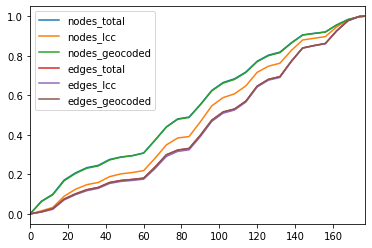

In [15]:
### Convert to proportions:
dft_prop_hrv = dft_hrv[['nodes_total', 'nodes_lcc', 'nodes_geocoded', 
            'edges_total', 'edges_lcc', 'edges_geocoded']]
dft_prop_hrv = dft_prop_hrv/dft_prop_hrv.max()
dft_prop_hrv.plot.line()

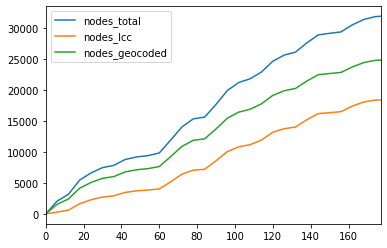

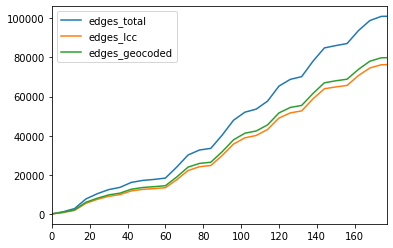

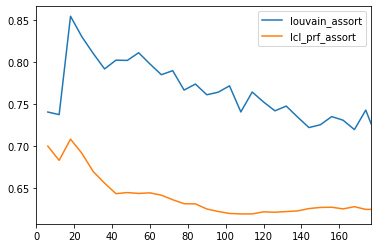

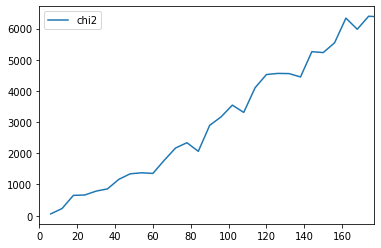

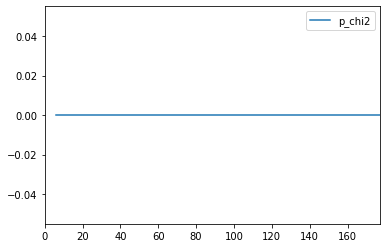

In [16]:
dft_hrv[['nodes_total', 'nodes_lcc', 'nodes_geocoded']].plot.line()
dft_hrv[['edges_total', 'edges_lcc', 'edges_geocoded']].plot.line()

dft_hrv[['louvain_assort', 'lcl_prf_assort']].plot.line()

dft_hrv[['chi2']].plot.line()
#dft_hrv[['r_pb', 'r_rho']].plot.line()
dft_hrv[['p_chi2']].plot.line()
#dft_hrv[['p_pb']].plot.line()
#dft_hrv[['p_rho']].plot.line()

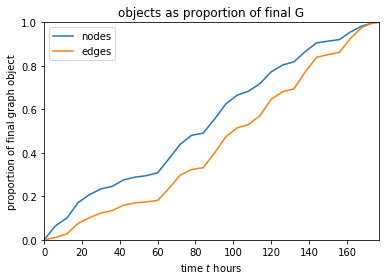

In [17]:
# Save figures to file for export to latex 
from matplotlib import pyplot as plt

ax = plt.axes()

cols = ['nodes_total', 'edges_total']
dft_prop_hrv[cols].rename(
        columns={k:k[:-6] for k in cols}
    ).plot.line(
        title='objects as proportion of final G', ax=ax)

#plt.xticks([])
plt.ylim([0,1])
plt.xlabel('time $t$ hours')
plt.ylabel('proportion of final graph object')

plt.savefig(LATEX_DIR + 'growth-over-t-hrv.png', bbox_inches='tight')

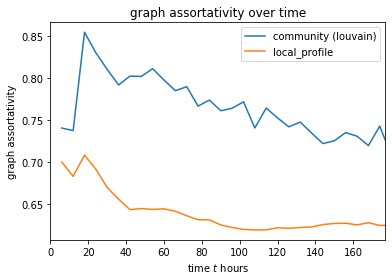

In [18]:
# Save figures to file for export to latex 
from matplotlib import pyplot as plt

ax = plt.axes()

cols = {'louvain_assort':'community (louvain)', 'lcl_prf_assort':'local_profile'}

dft_hrv[cols].rename(columns=cols).plot.line(
        title='graph assortativity over time', ax=ax)

plt.xlabel('time $t$ hours')
plt.ylabel('graph assortativity')

plt.savefig(LATEX_DIR + 'assort-over-t-hrv.png', bbox_inches='tight')
#plt.show()

In [20]:
set_tex_var('timeWindowHrs', int_to_str(BLOCK_HOURS), desc='Hours separating each G object slice.')

### Florence

In [21]:
# Repeat process for Florence
G = nx.read_gexf(FLR_GEXF)
dft_flr = get_graph_objects_time_sliced(G, BLOCK_HOURS, FILENAME=FLR_GEXF, OVERWRITE=True)

# Write to DF for convenience
CSV_FILENAME = FLR_GEXF[:-5] + '_tsliceDF.csv'
dft_flr.to_csv(CSV_FILENAME)
#dft_flr = pd.read_csv(CSV_FILENAME, index_col=0)

# Create proportion DF
dft_prop_flr = dft_flr[['nodes_total', 'nodes_lcc', 'nodes_geocoded', 
            'edges_total', 'edges_lcc', 'edges_geocoded']]
dft_prop_flr = dft_prop_flr/dft_prop_flr.max()

Creating time slice 1 of 27...
Calculating community metrics...
Calculating community metrics for graph. 5330 nodes and 29719 edges...
Largest component contains 3597 nodes (67.5%) and 23055 edges (99.9%).
Calculating c_label_prop...
Calculating c_label_prop_asyn...
Calculating c_louvain...
Calculating c_fluid...
Writing Gt to file...
Creating time slice 2 of 27...
Calculating community metrics...
Calculating community metrics for graph. 8080 nodes and 55636 edges...
Largest component contains 5536 nodes (68.5%) and 41872 edges (99.9%).
Calculating c_label_prop...
Calculating c_label_prop_asyn...
Calculating c_louvain...
Calculating c_fluid...
Writing Gt to file...
Creating time slice 3 of 27...
Calculating community metrics...
Calculating community metrics for graph. 10706 nodes and 98564 edges...
Largest component contains 7683 nodes (71.8%) and 73705 edges (99.9%).
Calculating c_label_prop...
Calculating c_label_prop_asyn...
Calculating c_louvain...
Calculating c_fluid...
Writing Gt

Writing Gt to file...
Creating time slice 25 of 27...
Calculating community metrics...
Calculating community metrics for graph. 89800 nodes and 2469201 edges...
Largest component contains 74400 nodes (82.9%) and 1709759 edges (100.0%).
Calculating c_label_prop...
Calculating c_label_prop_asyn...
Calculating c_louvain...
Calculating c_fluid...
Writing Gt to file...
Creating time slice 26 of 27...
Calculating community metrics...
Calculating community metrics for graph. 93194 nodes and 2603833 edges...
Largest component contains 77266 nodes (82.9%) and 1799631 edges (100.0%).
Calculating c_label_prop...
Calculating c_label_prop_asyn...
Calculating c_louvain...
Calculating c_fluid...
Writing Gt to file...
Creating time slice 27 of 27...
Calculating community metrics...
Calculating community metrics for graph. 96757 nodes and 2759570 edges...
Largest component contains 80398 nodes (83.1%) and 1908519 edges (100.0%).
Calculating c_label_prop...
Calculating c_label_prop_asyn...
Calculating c

/home/rosles/projects/crisis-data/venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


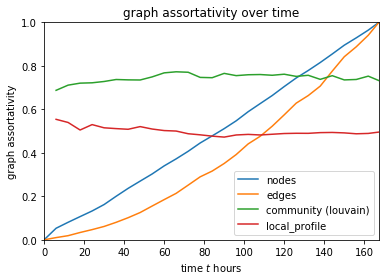

In [22]:
# Save figures to file for export to latex
# TODO: if side-by-side, remove y label and resize?
ax = plt.axes()
cols = ['nodes_total', 'edges_total']
dft_prop_flr[cols].rename(columns={k:k[:-6] for k in cols}).plot.line(
    title='objects as proportion of final G', ax=ax)
plt.ylim([0,1])
plt.xlabel('time $t$ hours')
plt.ylabel('proportion of final graph object')
plt.savefig(LATEX_DIR + 'growth-over-t-flr.png', bbox_inches='tight')


ax = plt.axes()
cols = {'louvain_assort':'community (louvain)', 'lcl_prf_assort':'local_profile'}
dft_flr[cols].rename(columns=cols).plot.line(
    title='graph assortativity over time', ax=ax)
plt.xlabel('time $t$ hours')
plt.ylabel('graph assortativity')
plt.savefig(LATEX_DIR + 'assort-over-t-flr.png', bbox_inches='tight')

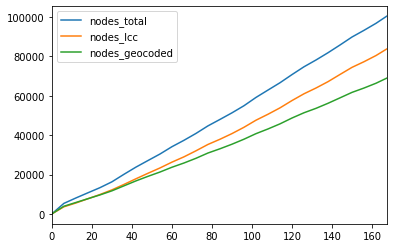

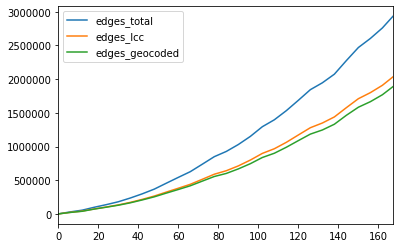

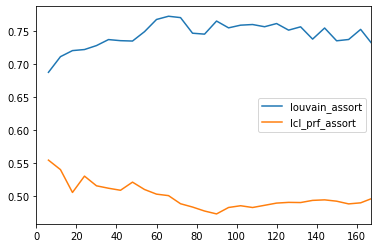

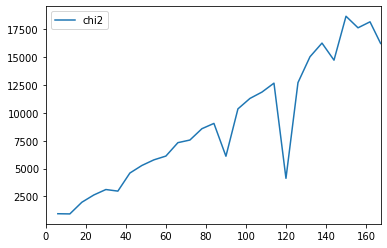

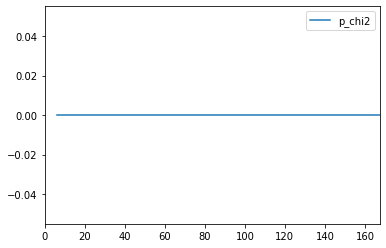

In [23]:
# General exploration of graphs:
dft_flr[['nodes_total', 'nodes_lcc', 'nodes_geocoded']].plot.line()
dft_flr[['edges_total', 'edges_lcc', 'edges_geocoded']].plot.line()
dft_flr[['louvain_assort', 'lcl_prf_assort']].plot.line()
dft_flr[['chi2']].plot.line()
dft_flr[['p_chi2']].plot.line()

### Mixed Graphs

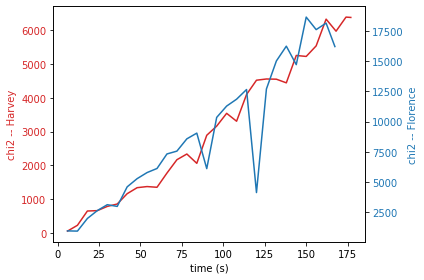

In [24]:
# Creating two plots with different scales
# From: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html

import numpy as np
import matplotlib.pyplot as plt

data1 = dft_hrv[['chi2']]
data2 = dft_flr[['chi2']]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('chi2 -- Harvey', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('chi2 -- Florence', color=color)  # we already handled the x-label with ax1
ax2.plot(data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.savefig(LATEX_DIR + 'chi2-over-t.png', bbox_inches='tight')
#plt.show()